# Reconstruction with real data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate_z0
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import ab_initio
import jax

import mrcfile

plt.rcParams["figure.figsize"]=8,8

### Read the data

In [3]:
#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/CaltechWeaver/"
#star_file = "job550_particles_subsamp5_10000_30_40_2.star"
#star_file = "job550_particles_roy40k.star"
#star_file = "job550_particles.star"


#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/Frost/eIF2B/job042/"
#star_file = "AUG11_99Kparticles_updatedGCTF.star"

#data_dir = "/project/lederman/rrl28/share/CryoEMDataSmall/RelionSample/relion30_tutorial_precalculated_results/"
#star_file = "Extract/job020/particles.star"

data_dir = "/gpfs/gibbs/pi/lederman/dge5/RELION_TUTORIAL_SET/PrecalculatedResults/"
star_file = "/Extract/job018/particles.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)
ctf_params0 = params0["ctf_params"]
pixel_size0 = params0["pixel_size"]
angles0 = params0["angles"]
shifts0 = params0["shifts"]


/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles:  4501
load_data: data loaded, time:  6.1276445388793945


In [4]:
print(imgs0.shape)
print(pixel_size0.shape)
print(angles0.shape)
print(shifts0.shape)
print(ctf_params0.shape)

#plt.imshow(np.abs(jnp.fft.fftshift(imgs_f0[101]))); plt.colorbar()

(4501, 256, 256)
(4501,)
(4501, 3)
(4501, 2)
(4501, 9)


### Only keep the first N points (to avoid out of memory error)

In [5]:
N = 10000
imgs = imgs0[:N]
pixel_size = pixel_size0[:N]
angles = angles0[:N]
shifts = shifts0[:N]
ctf_params = ctf_params0[:N]

### Some angle filtering

In [6]:
#idx = jnp.abs(angles0[:,2]) < jnp.pi/4
#imgs_f = imgs_f0[idx]
#pixel_size = pixel_size0[idx]
#angles = angles0[idx]
#shifts = shifts0[idx]
#ctf_params = ctf_params0[idx]

#idx2 = jnp.abs(angles[:,1]) < jnp.pi/3
#imgs_f = imgs_f[idx2]
#pixel_size = pixel_size[idx2]
#angles = angles[idx2]
#shifts = shifts[idx2]
#ctf_params = ctf_params[idx2]

#plot_angles(angles)

### Take the FFT of the images

In [7]:
imgs_f = np.array([np.fft.fft2(np.fft.ifftshift(img)) for img in imgs0])

#del(imgs)

### Create the grids

In [8]:
# Assume the pixel size is the same for all images
nx = imgs_f.shape[-1]
px = pixel_size[0]
N = imgs_f.shape[0]

x_grid = create_grid(nx, px)
y_grid = x_grid
z_grid = x_grid
print(x_grid)

[3.13873258e-03 2.56000000e+02]


### Crop images to 32 x 32 

In [9]:
nx = 32
imgs_f, x_grid = crop_fourier_images(imgs_f, x_grid, nx)

y_grid = x_grid
z_grid = x_grid
print(x_grid)

[3.13873258e-03 3.20000000e+01]


### Before further processing, vectorize the images, create mask etc

In [10]:
imgs_f = imgs_f.reshape(N, -1)
print(imgs_f.shape)

(4501, 1024)


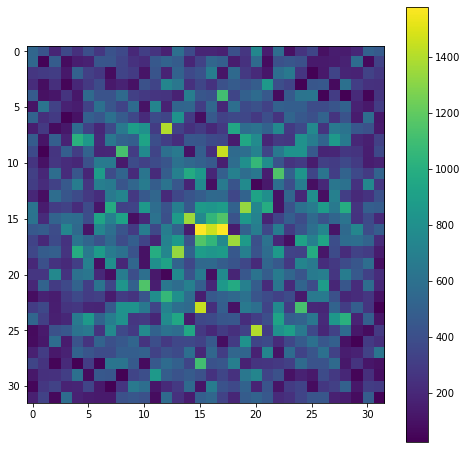

In [11]:
plt.imshow(jnp.abs(jnp.fft.fftshift(jnp.array(imgs_f[101].reshape(nx,nx)))));plt.colorbar()

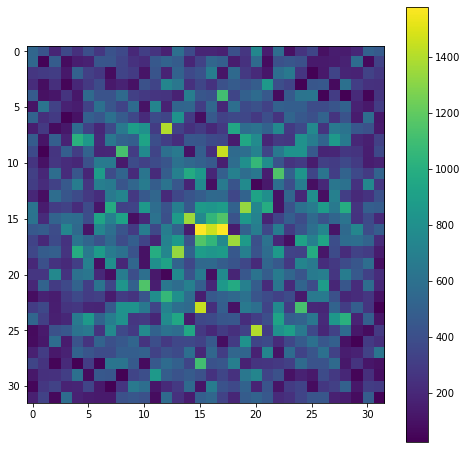

In [12]:
plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[101].reshape(nx,nx)))); plt.colorbar()

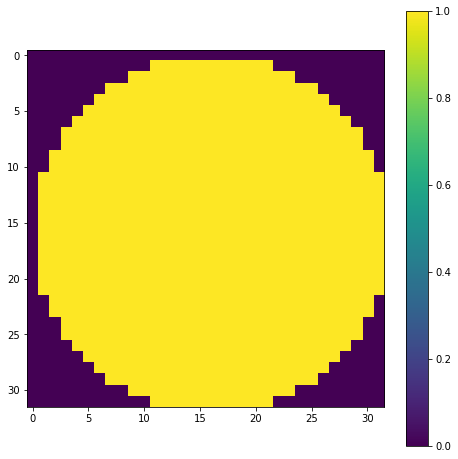

In [13]:
centre = (0,0,0)
radius = 0.05
#radius = 0.07 # for nx=64
#radius = 0.14 # for nx=128
#radius = 0.28 # for nx=256

mask = create_3d_mask(x_grid, centre, radius)


mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

### Noise

First, decide on the dimensions of the empty corners to use for noise estimation:

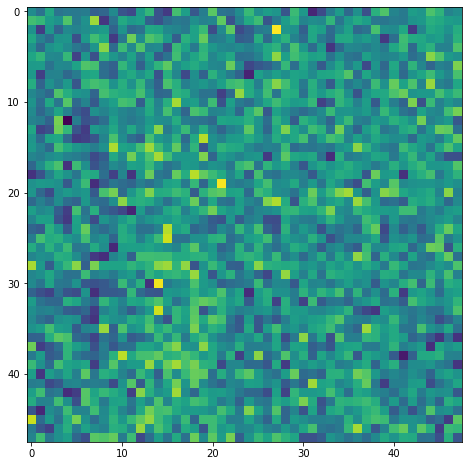

In [14]:
plt.imshow(jnp.mean(imgs0[:,:48,:48], axis=0))

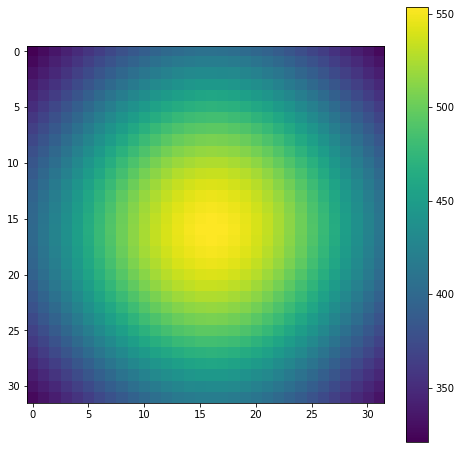

In [15]:
sigma_noise = estimate_noise_imgs(imgs0, nx_empty = 12, nx_final = 32)
plt.imshow(jnp.fft.fftshift(sigma_noise.reshape([32,32]))); plt.colorbar()

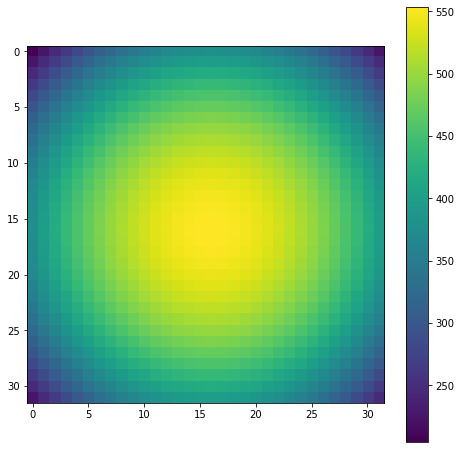

In [16]:
x_freq = jnp.fft.fftfreq(x_grid[1].astype(np.int64), 1/(x_grid[1] * x_grid[0]))
X,Y = jnp.meshgrid(x_freq, x_freq)
C = (jnp.max(sigma_noise)-jnp.min(sigma_noise))*1.5/jnp.max(X**2+Y**2)
r = jnp.max(sigma_noise) -(X**2 + Y**2)* C 
plt.imshow(jnp.fft.fftshift(r)); plt.colorbar()


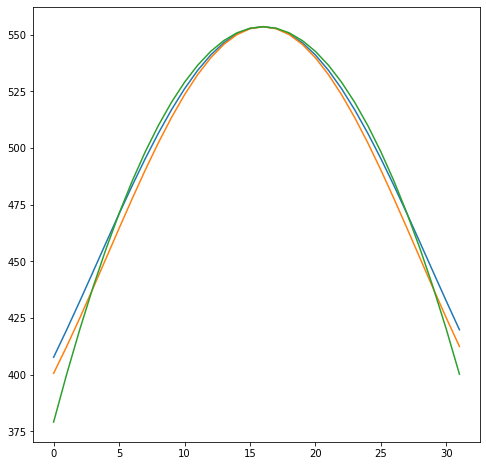

In [17]:
s = (sigma_noise.reshape([32,32]))
plt.plot(jnp.fft.fftshift(s[:,0]))
plt.plot(jnp.fft.fftshift(s[0,:]))
plt.plot(jnp.fft.fftshift(r[:,0]))

In [18]:
sigma_noise = r.reshape(-1)

### Forward model and loss functon

In [19]:
alpha = 0.1

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)

grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

Test the functions above with a random volume

In [20]:
vf = jnp.array(np.random.randn(nx,nx,nx))
sf = slice_func(vf, angles[0], shifts[0], ctf_params[0])
sf.shape

(1024,)

In [21]:
start = time.time()
ll = grad_loss_volume(vf, angles[0], shifts[0], ctf_params[0], imgs_f[0], sigma=1)
print(time.time()-start)
print(ll.shape)

2.1832330226898193
(32, 32, 32)


In [22]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(vf, angles[idx], shifts[idx], ctf_params[idx], imgs_f[idx], sigma=1)
print(time.time()-start)
print(ll.shape)

2.430650472640991
(32, 32, 32)


### Ab initio

In [23]:
print(x_grid[0]*x_grid[1]/2)
print(x_grid[0])

0.05021972132474
0.00313873258279625


0.1
1.1
0.1


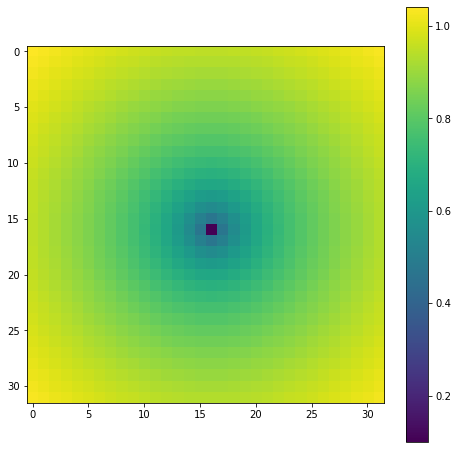

In [24]:
P = get_preconditioner(x_grid) 
#P = jnp.sqrt(P) /jnp.max(P) + 1e-6
#P = jnp.sqrt(P)
P = P**0.15
P = P /jnp.max(P)+ 0.1
plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))
print(jnp.min(P))

In [25]:
#old_stdout = sys.stdout
#sys.stdout = open('../data/relion/output.txt', 'w')

In [26]:
#sys.stdout = sys.__stdout__

  sgd epoch 0: mean gradient = 1.2414801702675312e-05
  sgd epoch 50: mean gradient = 4.785548096308288e-06
  sgd epoch 100: mean gradient = 2.8243401678729046e-06
  sgd epoch 150: mean gradient = 9.750762337536252e-07


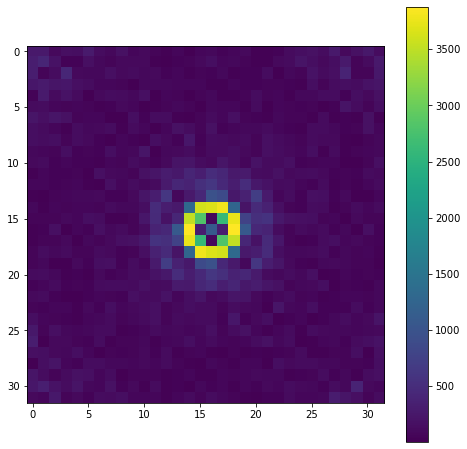

Iter  0
  Time orientations sampling = 1.824580430984497


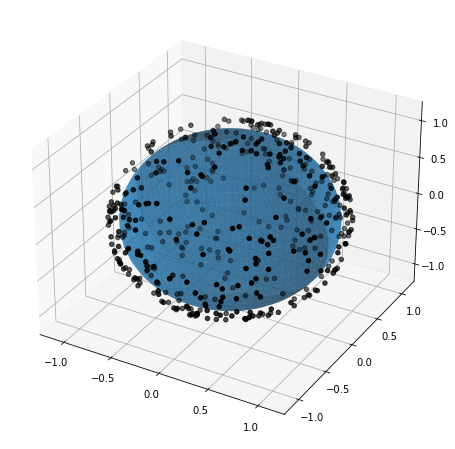

  sgd epoch 0: mean gradient = 3.2617953579872044e-05
  sgd epoch 50: mean gradient = 2.3007383770021244e-06
  sgd epoch 100: mean gradient = 1.0927093303707092e-06
  sgd epoch 150: mean gradient = 5.696187756179806e-07
  Time vol optimisation = 19.716295957565308


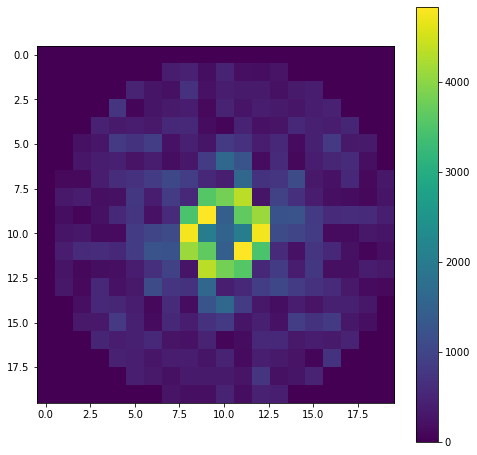

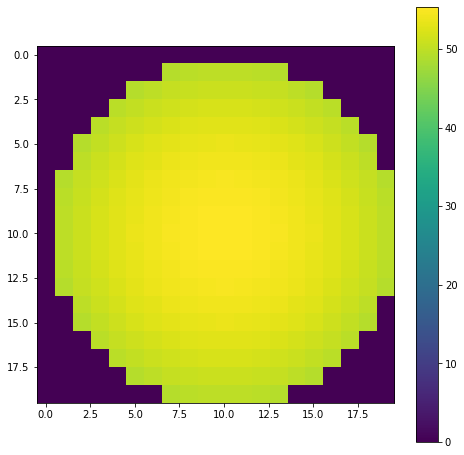

2022-02-17 09:28:23.377127
  nx = 20


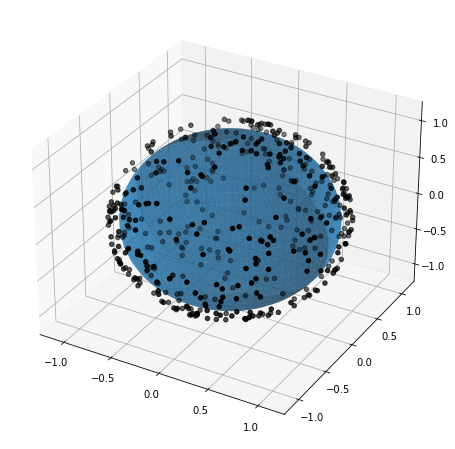

Iter  1
  Time orientations sampling = 1.800581932067871


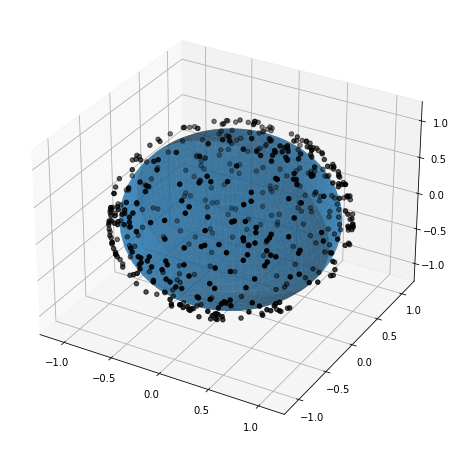

  sgd epoch 0: mean gradient = 2.4530846326554852e-05
  sgd epoch 50: mean gradient = 7.389354052009984e-07
  Time vol optimisation = 11.825860738754272


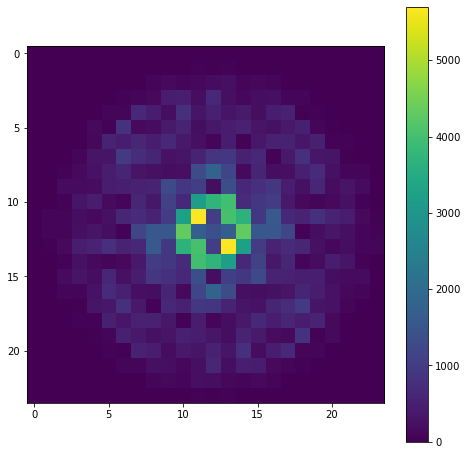

Iter  2
  Time orientations sampling = 1.773444652557373


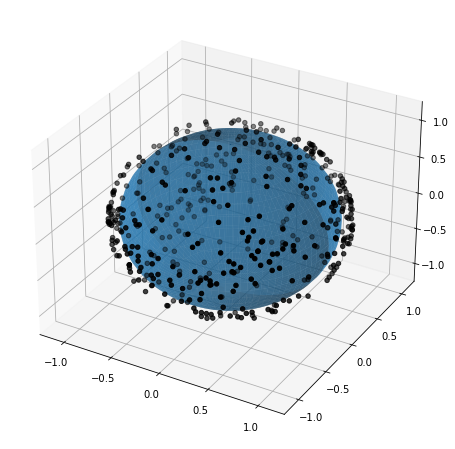

  sgd epoch 0: mean gradient = 2.533904317776572e-05
  sgd epoch 50: mean gradient = 1.9169313381313356e-06
  sgd epoch 100: mean gradient = 5.609703962335684e-07
  Time vol optimisation = 16.517930507659912


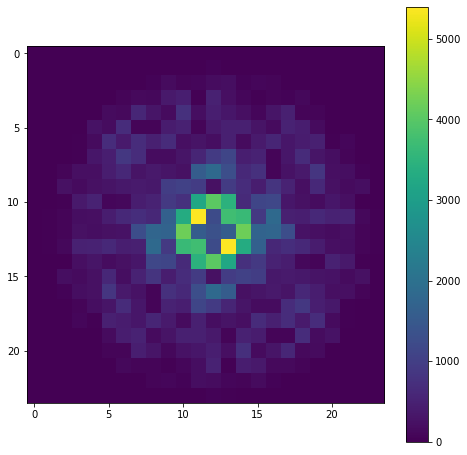

Iter  3
  Time orientations sampling = 1.7728972434997559


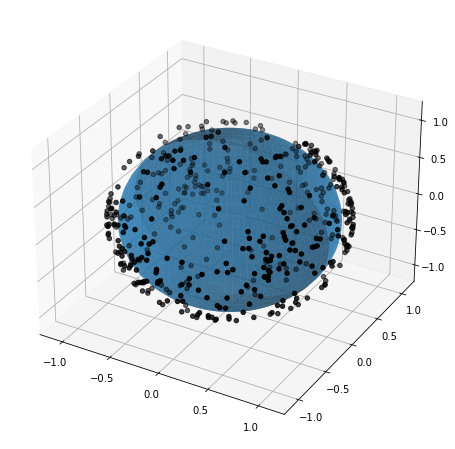

  sgd epoch 0: mean gradient = 2.646213540539105e-05
  sgd epoch 50: mean gradient = 1.1338989358388907e-06
  sgd epoch 100: mean gradient = 1.8873137715351116e-06
  sgd epoch 150: mean gradient = 4.847874134215449e-07
  Time vol optimisation = 21.83285927772522


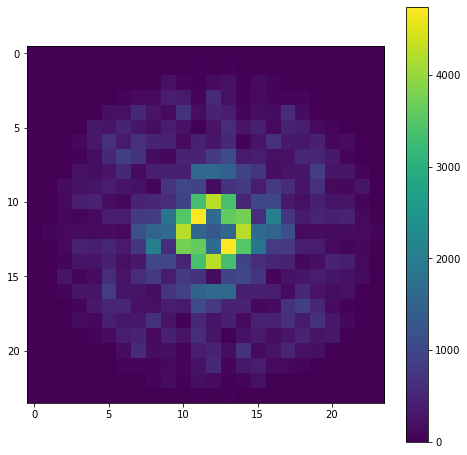

Iter  4
  Time orientations sampling = 2.4302570819854736


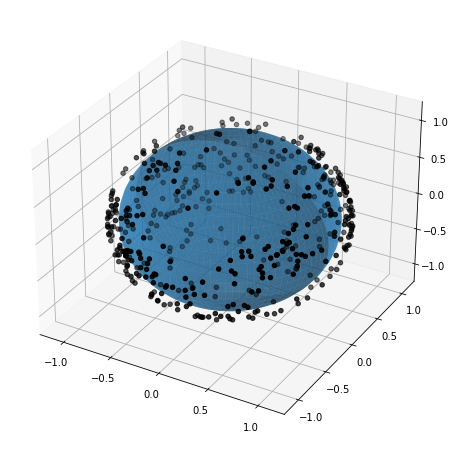

  sgd epoch 0: mean gradient = 2.732134557876607e-05
  sgd epoch 50: mean gradient = 3.256417150975999e-07
  Time vol optimisation = 11.700517892837524


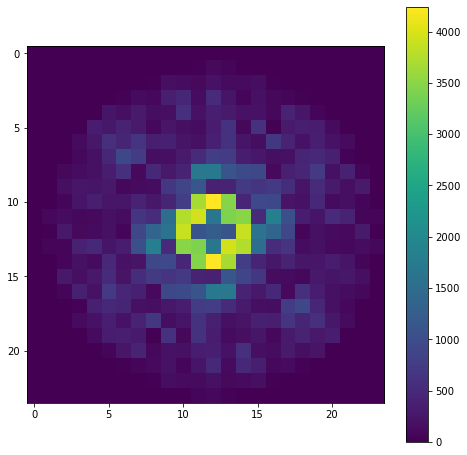

Iter  5
  Time orientations sampling = 1.8167481422424316


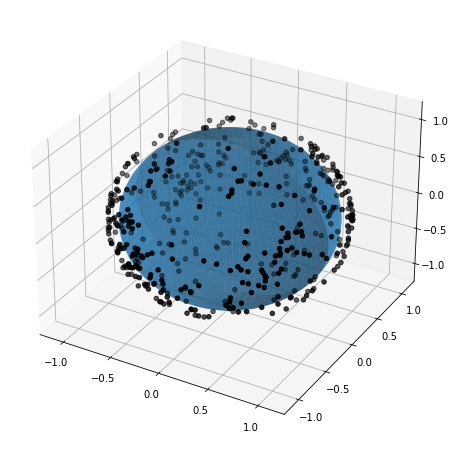

  sgd epoch 0: mean gradient = 2.9262669728460527e-05
  sgd epoch 50: mean gradient = 1.7408764912319698e-06
  sgd epoch 100: mean gradient = 1.2476463461251774e-06
  sgd epoch 150: mean gradient = 3.2184701163953895e-08
  Time vol optimisation = 22.004053831100464


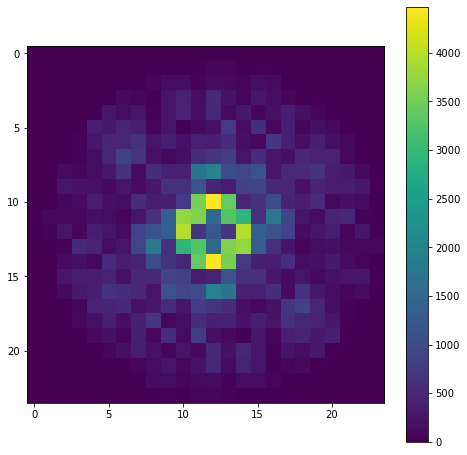

Iter  6
  Time orientations sampling = 2.4775822162628174


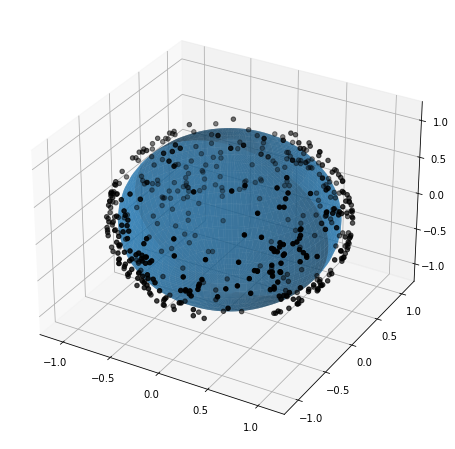

  sgd epoch 0: mean gradient = 2.5126457489687463e-05
  sgd epoch 50: mean gradient = 1.030084496097103e-06
  sgd epoch 100: mean gradient = 4.960968662444563e-07
  Time vol optimisation = 16.88063621520996


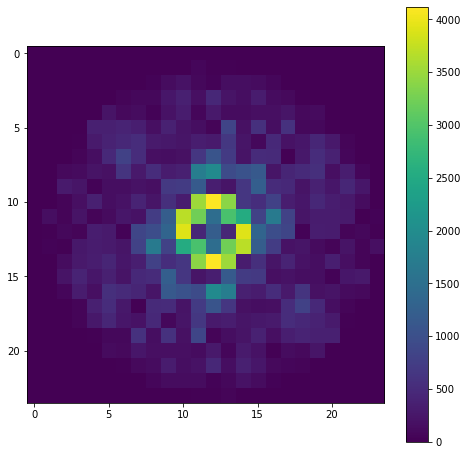

Iter  7
  Time orientations sampling = 1.874504566192627


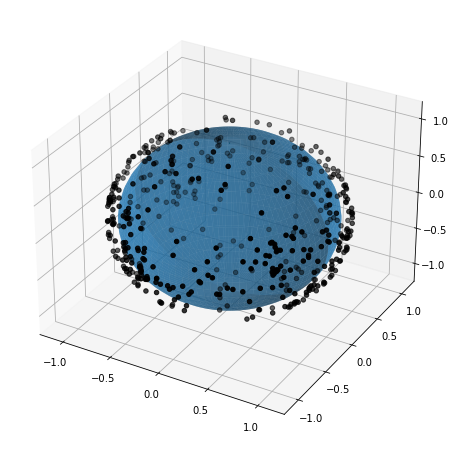

  sgd epoch 0: mean gradient = 2.4721800894347443e-05
  sgd epoch 50: mean gradient = 1.6344129420878415e-06
  sgd epoch 100: mean gradient = 9.992269560319252e-07
  Time vol optimisation = 16.647570848464966


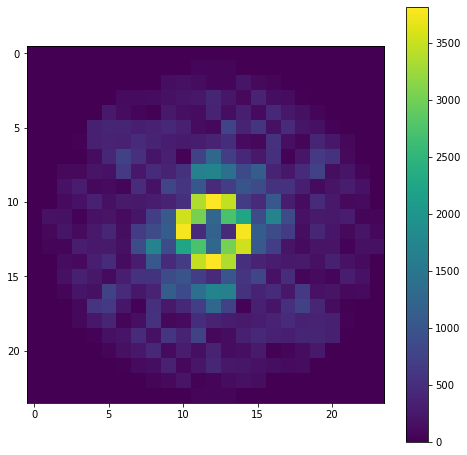

Iter  8
  Time orientations sampling = 1.8316009044647217


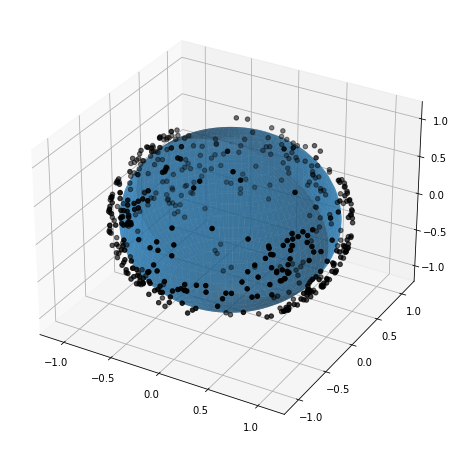

  sgd epoch 0: mean gradient = 2.579829828343836e-05
  sgd epoch 50: mean gradient = 1.3190194940705521e-06
  sgd epoch 100: mean gradient = 2.0834199567465077e-06
  sgd epoch 150: mean gradient = 1.2269996870923561e-06
  sgd epoch 200: mean gradient = 2.1682139491707364e-06
  sgd epoch 250: mean gradient = 2.6254438586759682e-06
  sgd epoch 300: mean gradient = 1.910568464169548e-06
  sgd epoch 350: mean gradient = 1.0304956797879497e-06
  sgd epoch 400: mean gradient = 2.3124134398596853e-07
  Time vol optimisation = 48.15507674217224


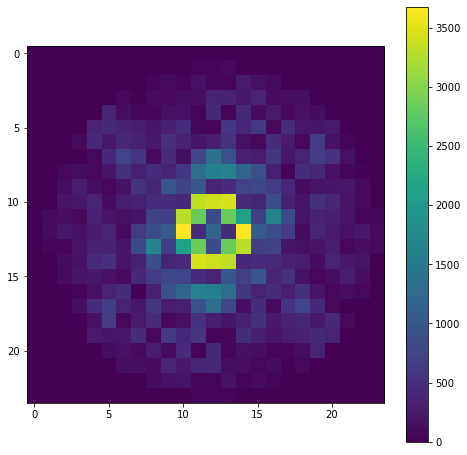

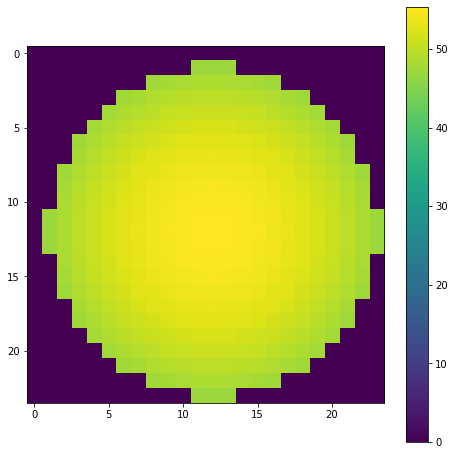

2022-02-17 09:33:10.257203
  nx = 24


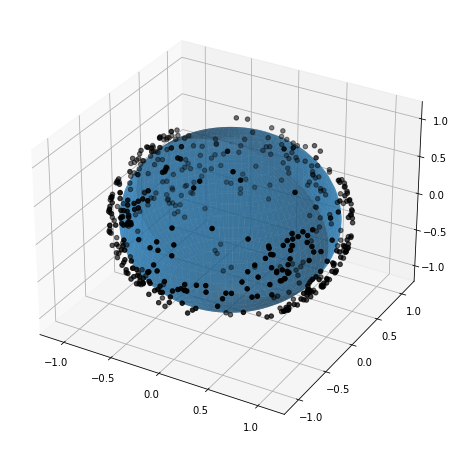

Iter  9
  Time orientations sampling = 2.6579692363739014


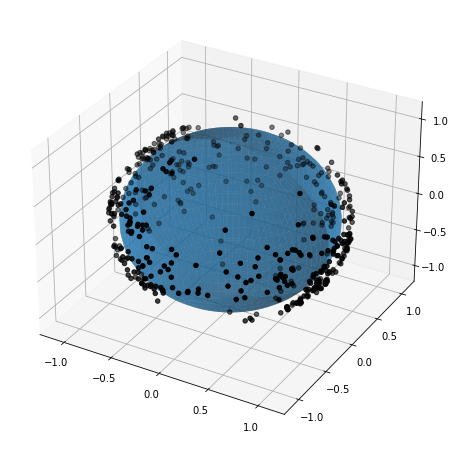

  sgd epoch 0: mean gradient = 1.922457493520068e-05
  sgd epoch 50: mean gradient = 5.822858255783888e-07
  Time vol optimisation = 13.24504280090332


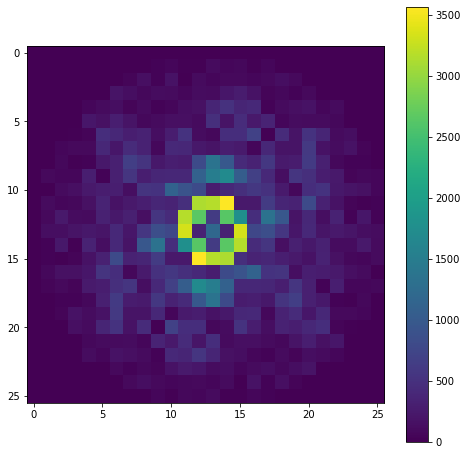

Iter  10
  Time orientations sampling = 1.8763389587402344


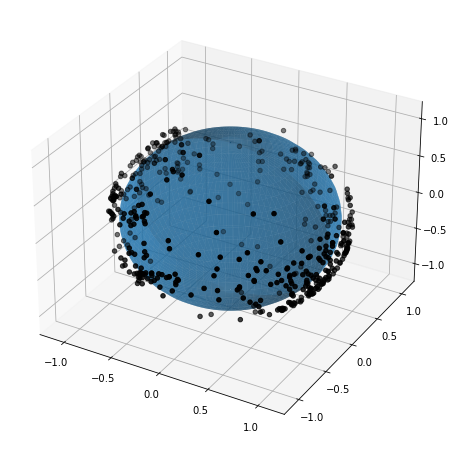

  sgd epoch 0: mean gradient = 2.107090214917001e-05
  sgd epoch 50: mean gradient = 3.5424156435962886e-06
  sgd epoch 100: mean gradient = 2.9792822092368517e-06
  sgd epoch 150: mean gradient = 8.942004169590252e-07
  Time vol optimisation = 25.068196773529053


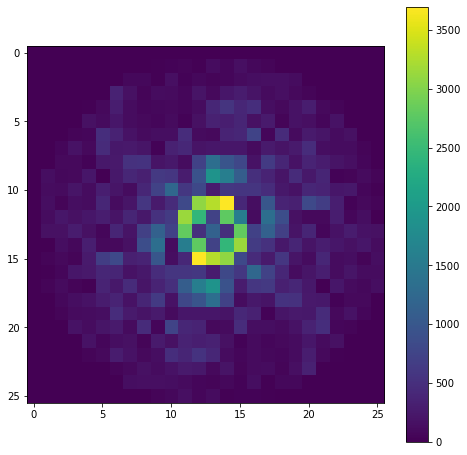

Iter  11
  Time orientations sampling = 1.8868892192840576


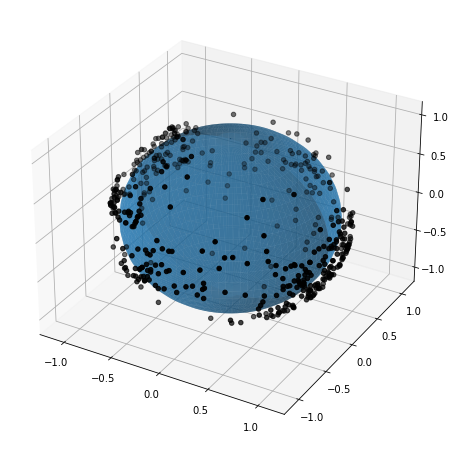

  sgd epoch 0: mean gradient = 2.0720713373311e-05
  sgd epoch 50: mean gradient = 2.9805309060201176e-06
  sgd epoch 100: mean gradient = 2.7383951415761014e-06
  sgd epoch 150: mean gradient = 2.660817179443886e-07
  Time vol optimisation = 24.04503560066223


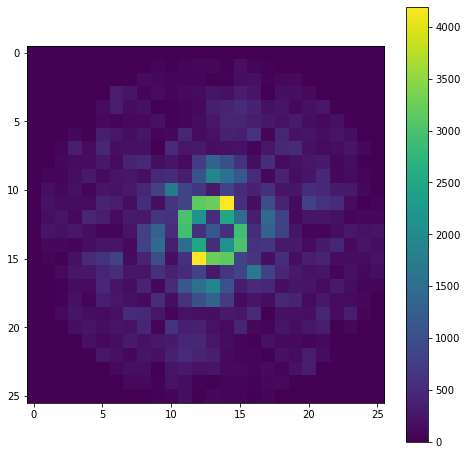

Iter  12
  Time orientations sampling = 1.8813724517822266


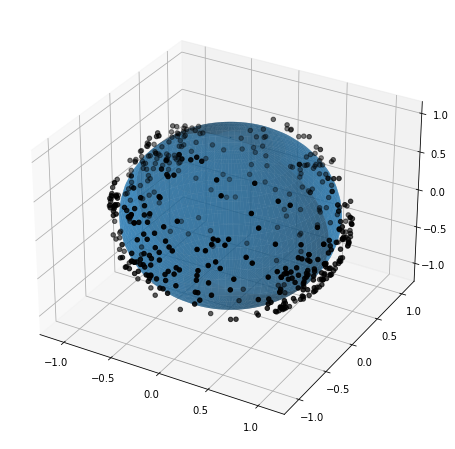

  sgd epoch 0: mean gradient = 1.7902696536966118e-05
  sgd epoch 50: mean gradient = 2.8617951402515154e-06
  sgd epoch 100: mean gradient = 1.6714582834651532e-06
  sgd epoch 150: mean gradient = 1.2616378226568593e-06
  sgd epoch 200: mean gradient = 2.6318918529519014e-06
  sgd epoch 250: mean gradient = 1.8568847227522928e-06
  sgd epoch 300: mean gradient = 1.5563613895976311e-06
  sgd epoch 350: mean gradient = 1.690218637271212e-06
  sgd epoch 400: mean gradient = 5.558748206663573e-08
  Time vol optimisation = 53.88332414627075


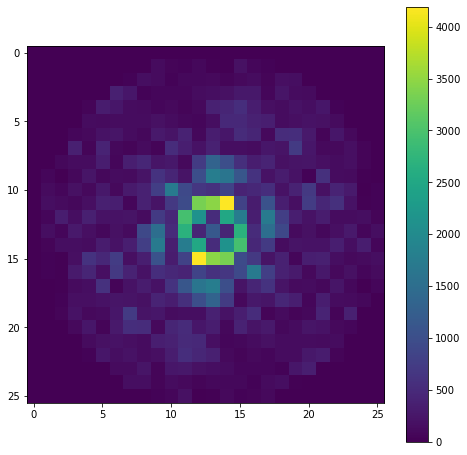

Iter  13
  Time orientations sampling = 2.682687997817993


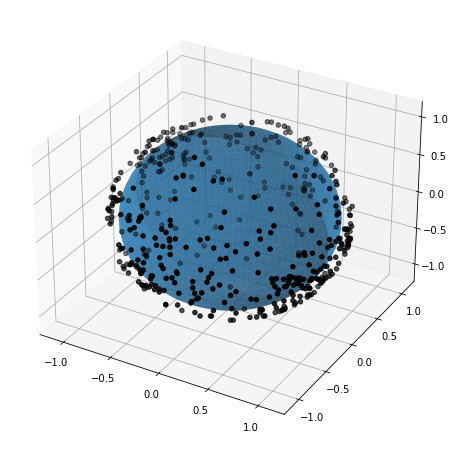

  sgd epoch 0: mean gradient = 1.8511810750169917e-05
  sgd epoch 50: mean gradient = 4.032284652764469e-06
  sgd epoch 100: mean gradient = 1.1466929732443262e-06
  sgd epoch 150: mean gradient = 1.7250949127912871e-06
  sgd epoch 200: mean gradient = 1.2653783679387693e-06
  sgd epoch 250: mean gradient = 1.2820874762114285e-07
  Time vol optimisation = 37.05487513542175


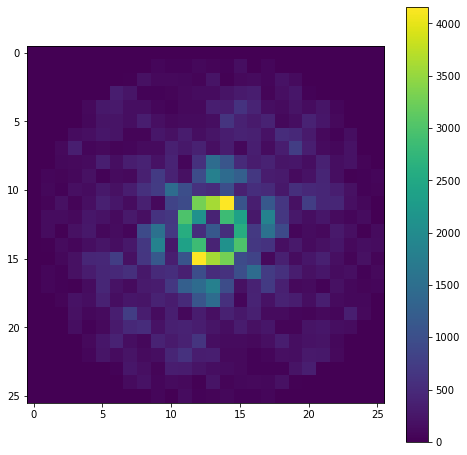

Iter  14
  Time orientations sampling = 1.996042013168335


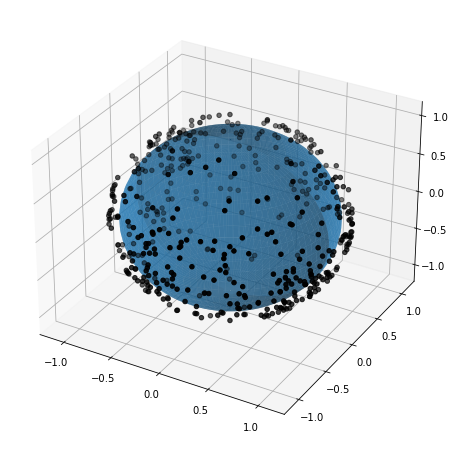

  sgd epoch 0: mean gradient = 1.866988435551299e-05
  sgd epoch 50: mean gradient = 6.346610830864995e-08
  Time vol optimisation = 12.327904462814331


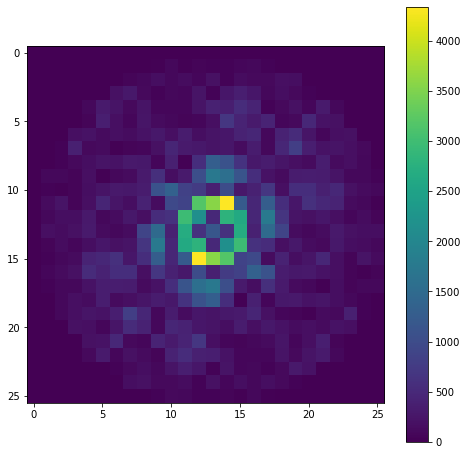

Iter  15
  Time orientations sampling = 1.9223525524139404


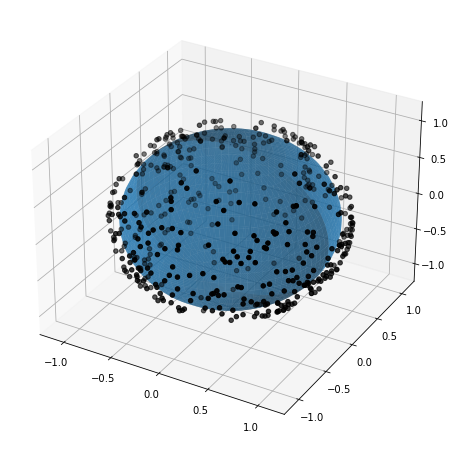

  sgd epoch 0: mean gradient = 1.8206603405096998e-05
  sgd epoch 50: mean gradient = 1.7597081223649548e-07
  Time vol optimisation = 13.118627309799194


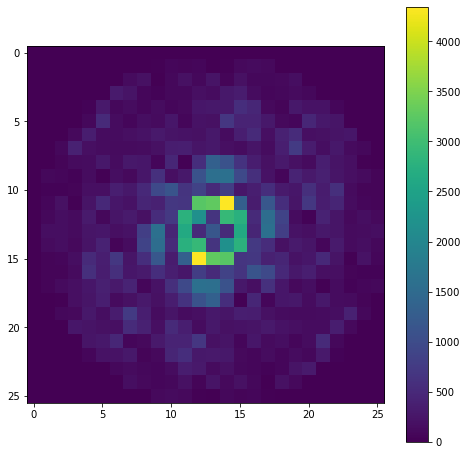

Iter  16
  Time orientations sampling = 1.94146728515625


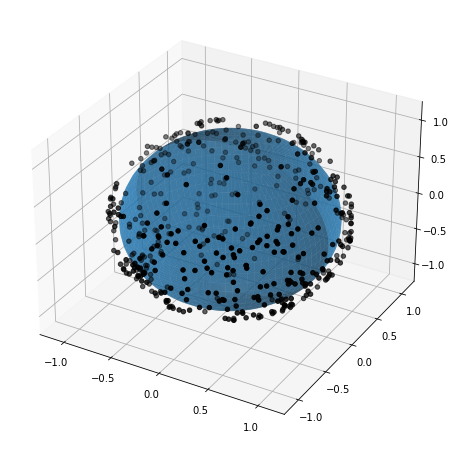

  sgd epoch 0: mean gradient = 1.980658340548267e-05
  sgd epoch 50: mean gradient = 2.867054294723683e-06
  sgd epoch 100: mean gradient = 1.2890776294635454e-07
  Time vol optimisation = 18.725947856903076


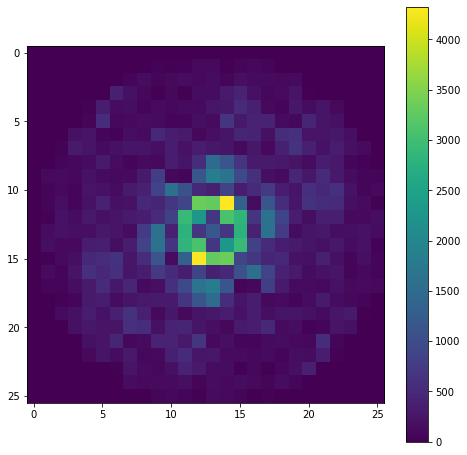

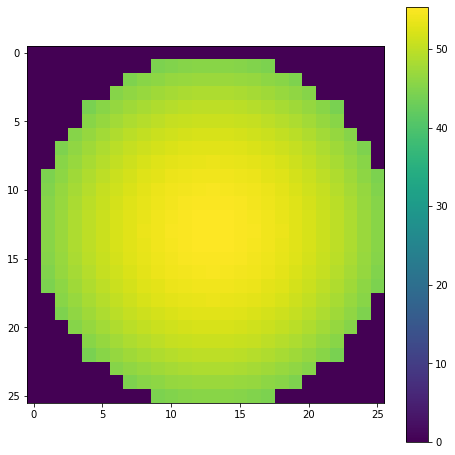

2022-02-17 09:38:45.655312
  nx = 26


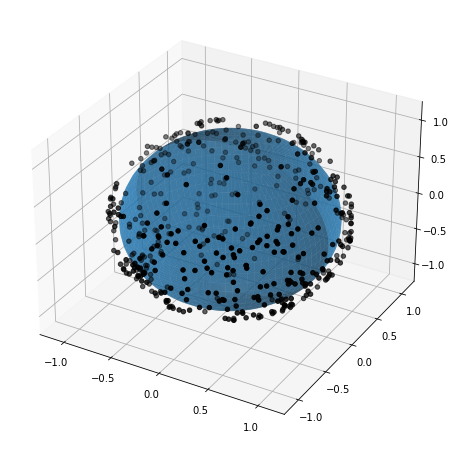

Iter  17
  Time orientations sampling = 3.022036552429199


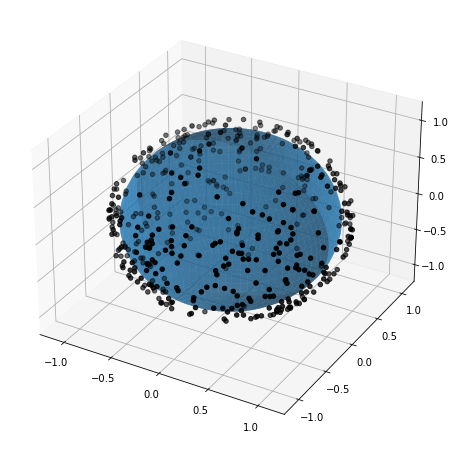

  sgd epoch 0: mean gradient = 1.414989872700268e-05
  sgd epoch 50: mean gradient = 3.295546111999164e-07
  Time vol optimisation = 16.10937237739563


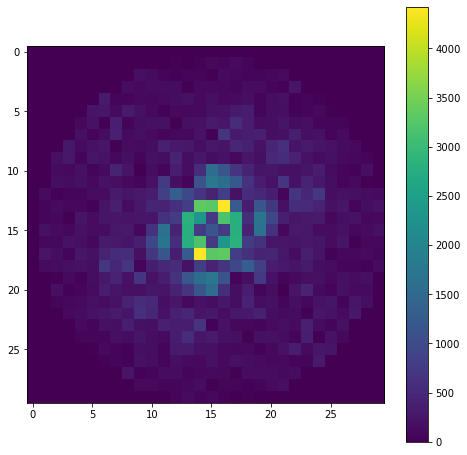

Iter  18
  Time orientations sampling = 1.9432218074798584


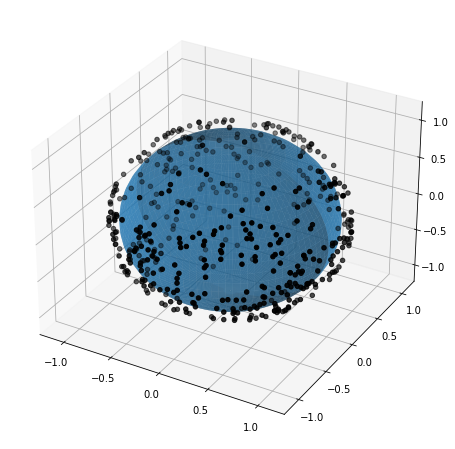

  sgd epoch 0: mean gradient = 1.564212140631527e-05
  sgd epoch 50: mean gradient = 7.549721529349057e-07
  Time vol optimisation = 14.648610353469849


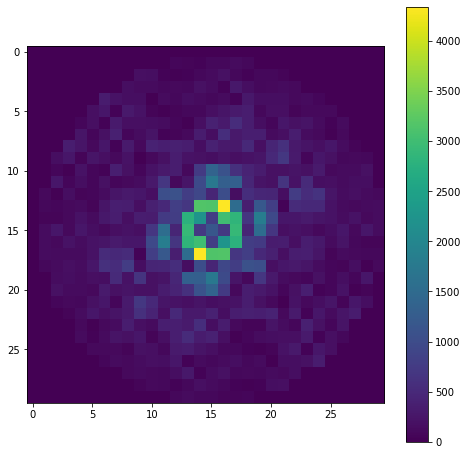

Iter  19
  Time orientations sampling = 1.944932222366333


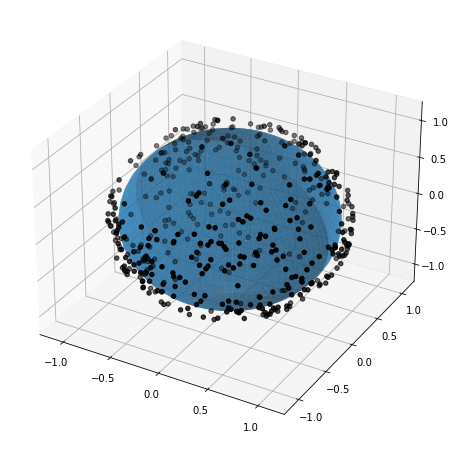

  sgd epoch 0: mean gradient = 1.1567086108081497e-05
  sgd epoch 50: mean gradient = 1.410852212756276e-06
  sgd epoch 100: mean gradient = 1.721765562283947e-06
  sgd epoch 150: mean gradient = 2.4256549002901467e-06
  sgd epoch 200: mean gradient = 1.6307402544290162e-07
  Time vol optimisation = 38.238401651382446


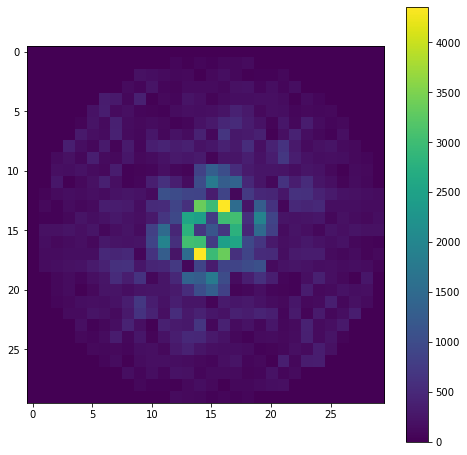

Iter  20
  Time orientations sampling = 1.9627685546875


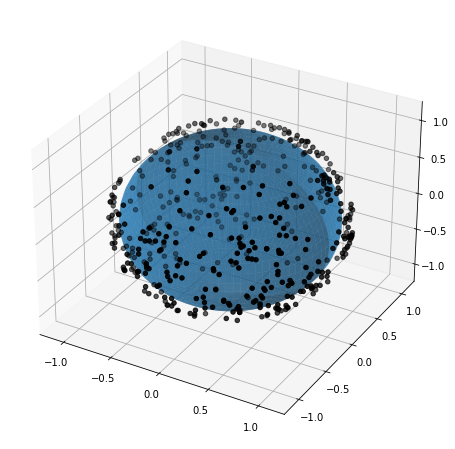

  sgd epoch 0: mean gradient = 1.5535385874760502e-05
  sgd epoch 50: mean gradient = 1.9070746678149225e-07
  Time vol optimisation = 15.36792254447937


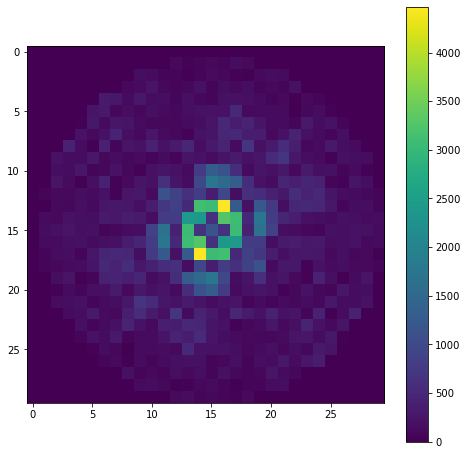

Iter  21
  Time orientations sampling = 1.9681117534637451


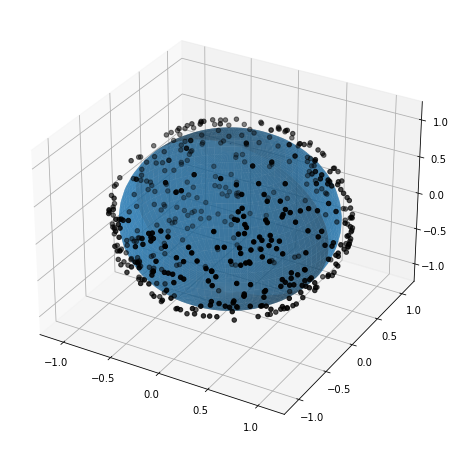

  sgd epoch 0: mean gradient = 1.2189071897155873e-05
  sgd epoch 50: mean gradient = 7.237201874982455e-07
  Time vol optimisation = 14.678018808364868


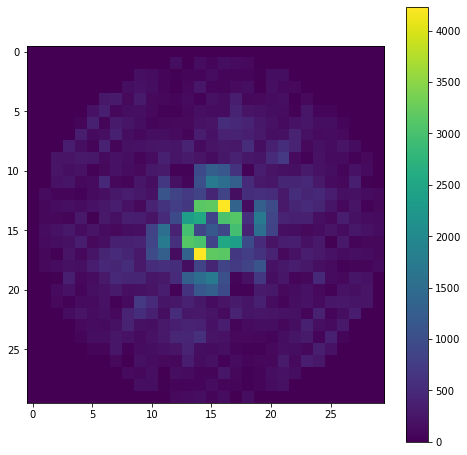

Iter  22
  Time orientations sampling = 2.1086511611938477


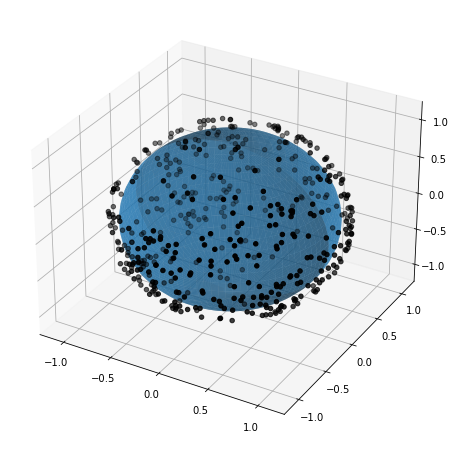

  sgd epoch 0: mean gradient = 1.3043702450022129e-05
  sgd epoch 50: mean gradient = 1.2152992891519682e-06
  sgd epoch 100: mean gradient = 1.2952305759934112e-06
  sgd epoch 150: mean gradient = 3.133396286722607e-07
  Time vol optimisation = 30.53516674041748


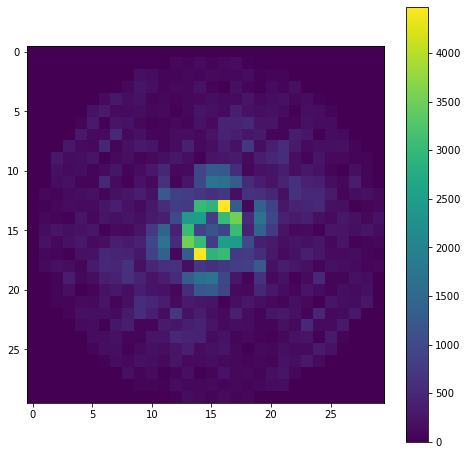

Iter  23
  Time orientations sampling = 2.89620304107666


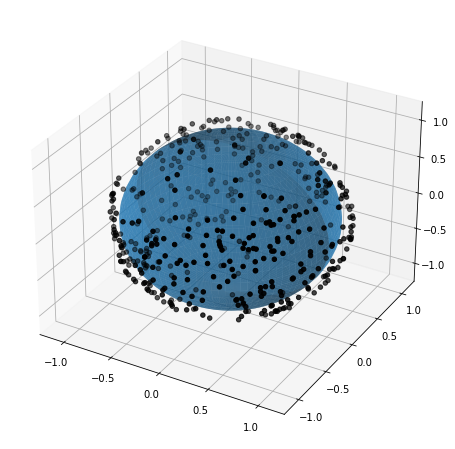

  sgd epoch 0: mean gradient = 1.3125234683902353e-05
  sgd epoch 50: mean gradient = 5.056196206344981e-07
  Time vol optimisation = 14.480724573135376


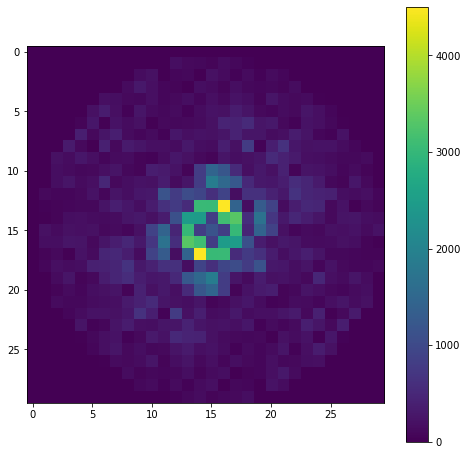

Iter  24
  Time orientations sampling = 2.03971529006958


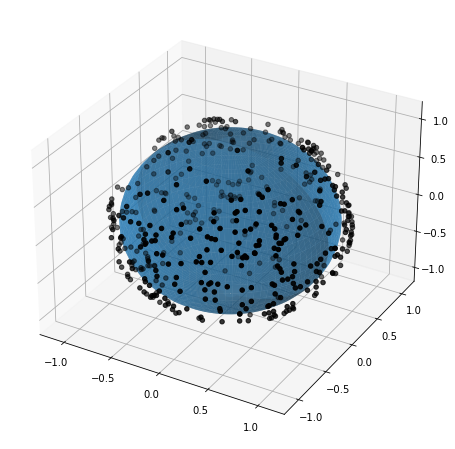

  sgd epoch 0: mean gradient = 1.3543048597837884e-05
  sgd epoch 50: mean gradient = 1.9529457615485346e-06
  sgd epoch 100: mean gradient = 4.281510448445717e-06
  sgd epoch 150: mean gradient = 6.184943776250753e-07
  Time vol optimisation = 30.992532968521118


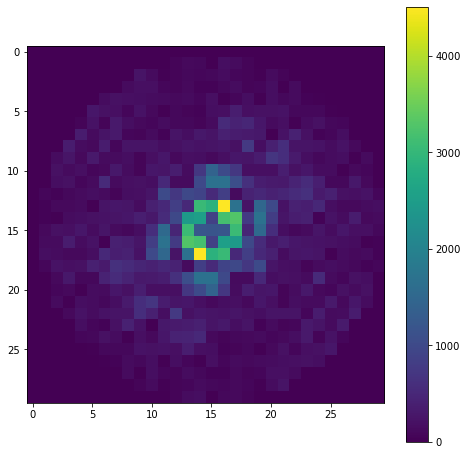

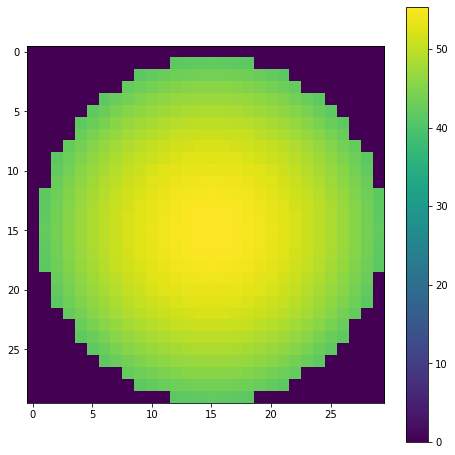

2022-02-17 09:44:26.990157
  nx = 30


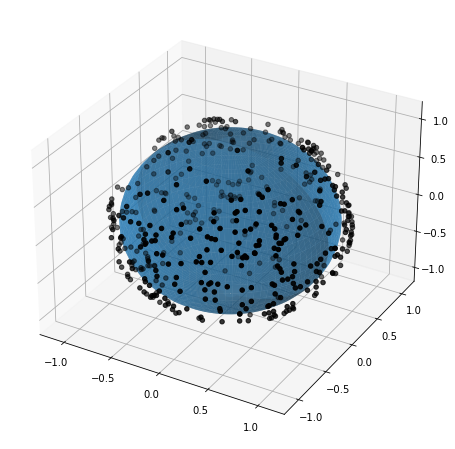

Iter  25
  Time orientations sampling = 2.938340663909912


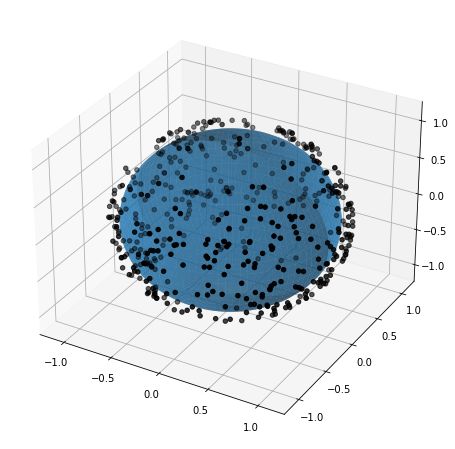

  sgd epoch 0: mean gradient = 1.3128682289241595e-05
  sgd epoch 50: mean gradient = 1.4280625509167582e-06
  sgd epoch 100: mean gradient = 2.8498292876319847e-06
  sgd epoch 150: mean gradient = 1.6948352459656962e-07
  Time vol optimisation = 34.72161555290222


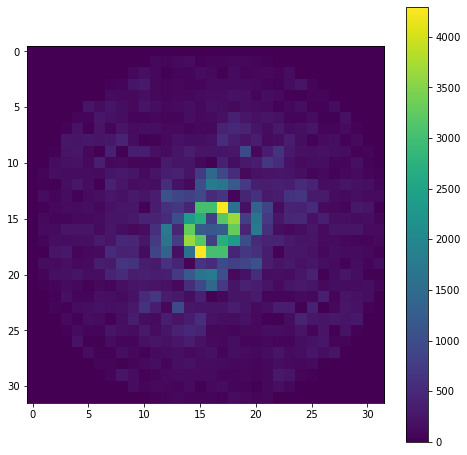

Iter  26
  Time orientations sampling = 2.0296871662139893


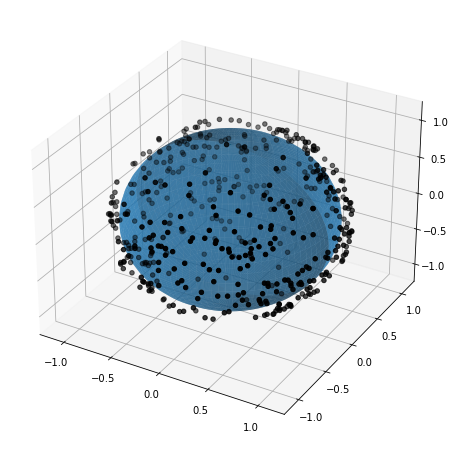

  sgd epoch 0: mean gradient = 1.1693619913950056e-05
  sgd epoch 50: mean gradient = 1.1384890822833996e-06
  sgd epoch 100: mean gradient = 9.575497390964917e-07
  Time vol optimisation = 24.27501106262207


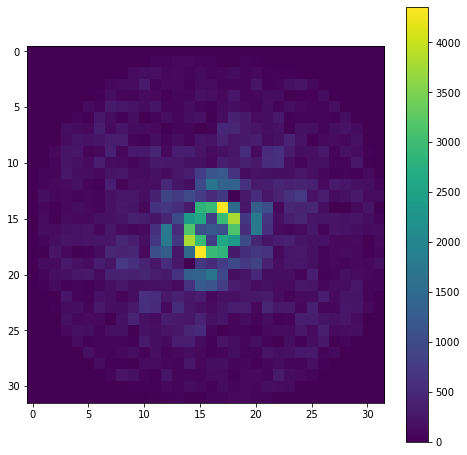

Iter  27
  Time orientations sampling = 2.028224468231201


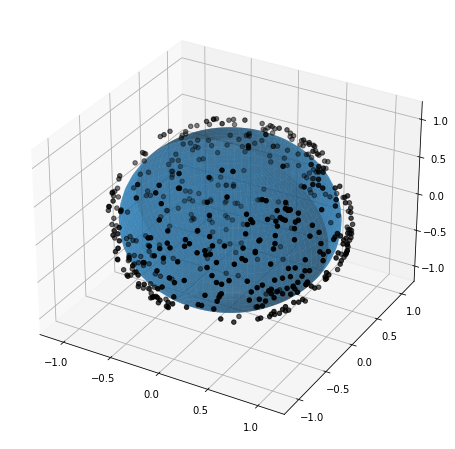

  sgd epoch 0: mean gradient = 9.007957204799482e-06
  sgd epoch 50: mean gradient = 4.822487309223021e-07
  Time vol optimisation = 15.486899852752686


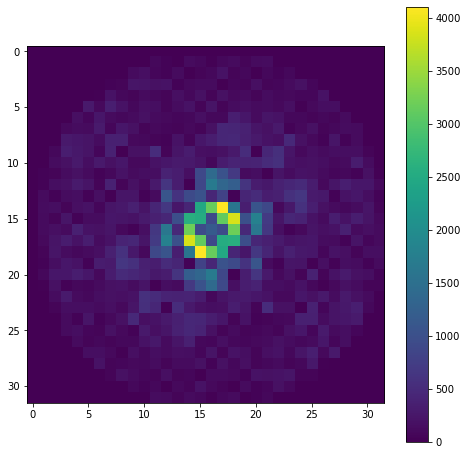

Iter  28
  Time orientations sampling = 2.0940346717834473


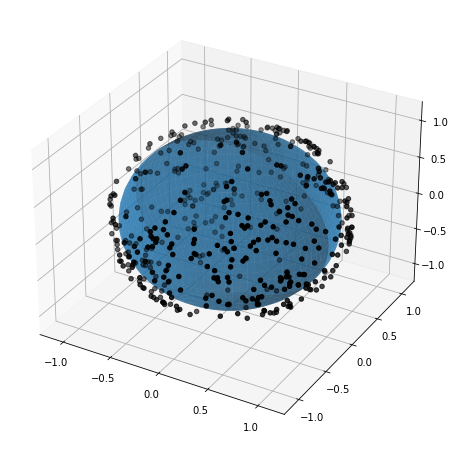

  sgd epoch 0: mean gradient = 1.3435166546983242e-05
  sgd epoch 50: mean gradient = 1.2639118858236665e-07
  Time vol optimisation = 16.37406039237976


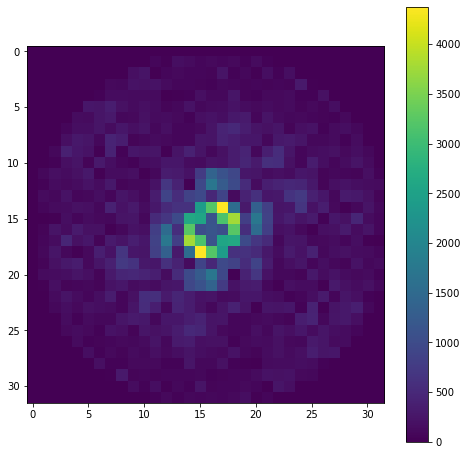

Iter  29
  Time orientations sampling = 1.9522485733032227


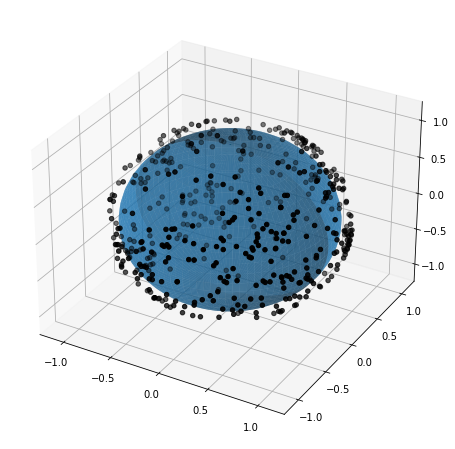

  sgd epoch 0: mean gradient = 1.358329443460987e-05
  sgd epoch 50: mean gradient = 3.0572664678622003e-06
  sgd epoch 100: mean gradient = 3.8843745400885065e-06
  sgd epoch 150: mean gradient = 7.396537080133053e-07
  Time vol optimisation = 33.05366396903992


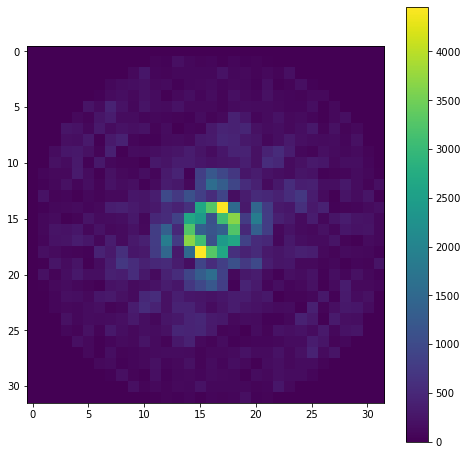

Iter  30
  Time orientations sampling = 1.986419439315796


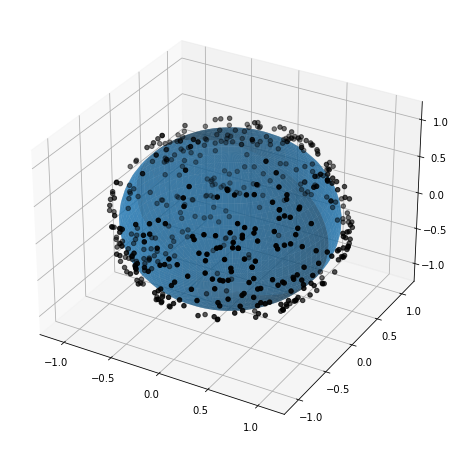

  sgd epoch 0: mean gradient = 1.4672515371853864e-05
  sgd epoch 50: mean gradient = 2.8913677030966247e-06
  sgd epoch 100: mean gradient = 4.083174963891131e-07
  Time vol optimisation = 24.345871686935425


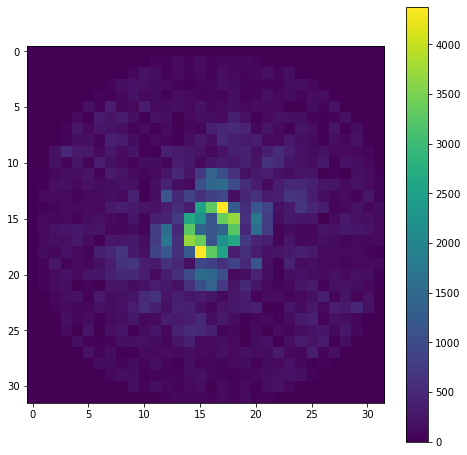

Iter  31
  Time orientations sampling = 2.9768335819244385


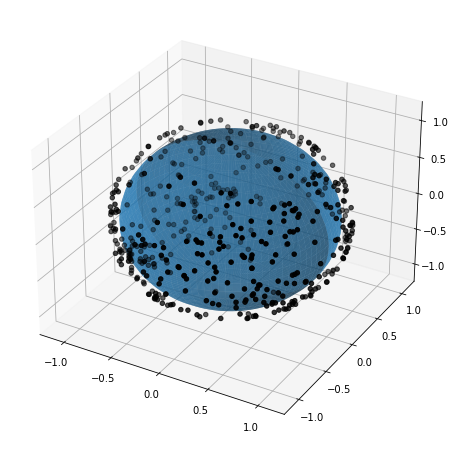

  sgd epoch 0: mean gradient = 1.3964001762015728e-05
  sgd epoch 50: mean gradient = 1.4095604425275293e-06
  sgd epoch 100: mean gradient = 1.9989374109334265e-06
  sgd epoch 150: mean gradient = 2.398148910163341e-06
  sgd epoch 200: mean gradient = 1.0371143582354347e-06
  sgd epoch 250: mean gradient = 1.54210014292493e-06
  sgd epoch 300: mean gradient = 1.3754244758692355e-06
  sgd epoch 350: mean gradient = 1.3715752886439132e-06
  sgd epoch 400: mean gradient = 9.013898326043167e-07
  Time vol optimisation = 78.4543628692627


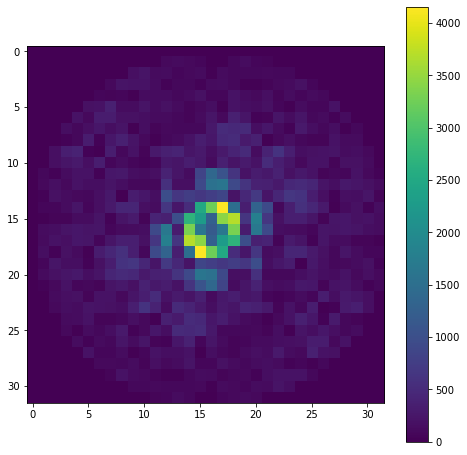

Iter  32
  Time orientations sampling = 1.9858546257019043


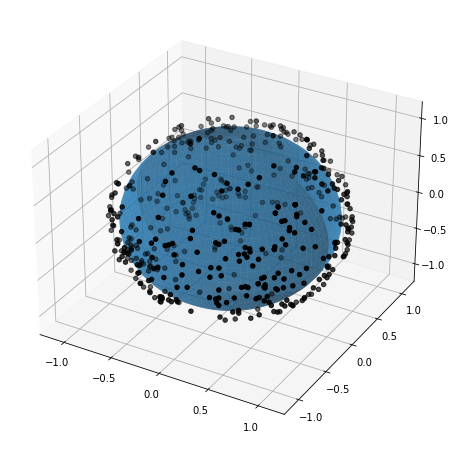

  sgd epoch 0: mean gradient = 1.0025400302766988e-05
  sgd epoch 50: mean gradient = 2.587380761543443e-06
  sgd epoch 100: mean gradient = 3.8172482888858563e-07
  Time vol optimisation = 24.666845560073853


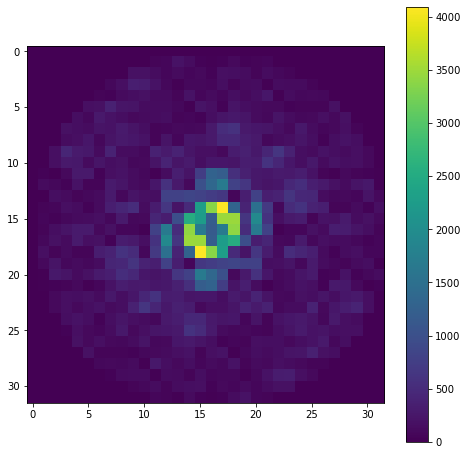

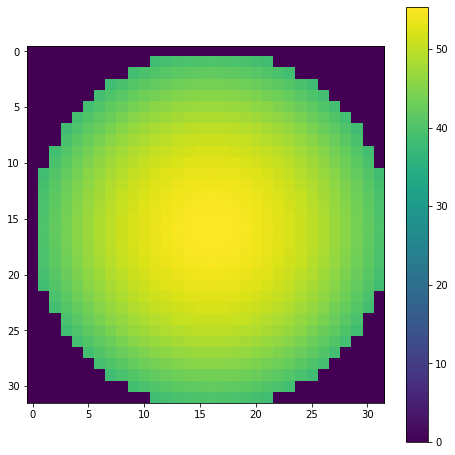

2022-02-17 09:51:31.462597
  nx = 32


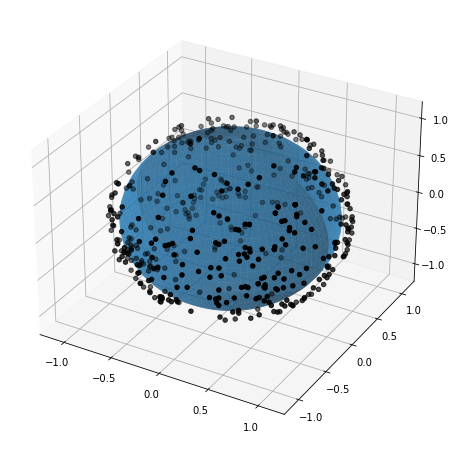

In [29]:
N_samples = 40000
N_iter = 10000

dr = 0.005
#dr = 0.003
#radius = 0.01
radius = 0.03
alpha = 1e-7
#alpha = 1e-5

use_sgd = True

N_cg_iter = 10000
eps_cg = 3e-5
#eps_cg = 1e-4

N_sgd_iter = 10000
batch_size = 300
#learning_rate = 1000
learning_rate = 10000
P = None
#eps_gd = 3e-8
eps_gd = 1e-6

if use_sgd:
    N_vol_iter = N_sgd_iter
    eps_vol = eps_gd
else:
    N_vol_iter = N_cg_iter
    eps_vol = eps_cg

out_dir = '../data/relion/'
imgs_f = imgs_f.reshape([N, nx*nx])


v_rec, angles_rec = ab_initio(project, imgs_f, sigma_noise/10, shifts, ctf_params, x_grid, use_sgd, N_iter, N_vol_iter, learning_rate, batch_size, P, N_samples, radius, dr, alpha, eps_vol, 'tri', True, True, True, out_dir)

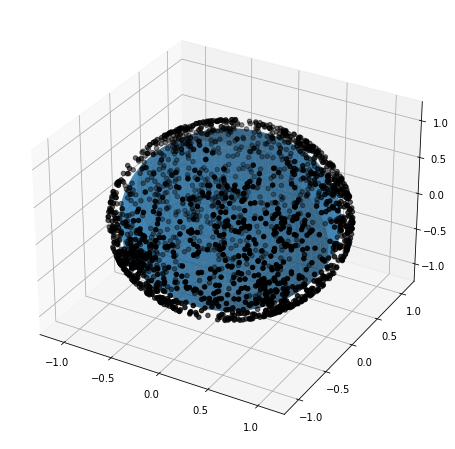

In [30]:
plot_angles(angles_rec[:2000])

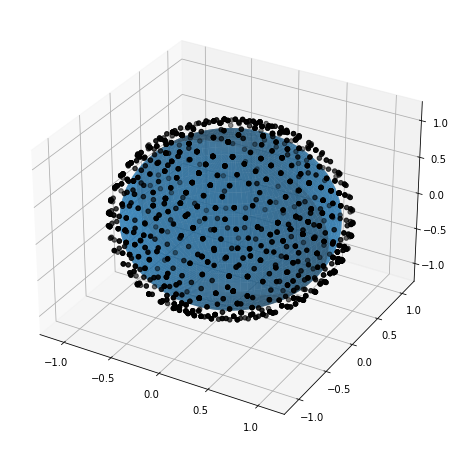

In [31]:
plot_angles(angles[:2000])

### CG

In [50]:
alpha = 1e-4
sigma_noise = estimate_real_noise(jnp.abs(imgs_f))
#sigma_noise = jnp.max(sigma_noise) * jnp.ones(sigma_noise.shape)

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

#v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
v0 = jnp.zeros([nx,nx,nx])* 1j
N_iter = 101

#N2 = jnp.floor(N/2).astype(jnp.int64)
N2 = 10000
AA1, Ab1 = get_cg_vol_ops(grad_loss_volume_sum, angles_rec[:N2], shifts[:N2], ctf_params[:N2], imgs_f[:N2], v0.shape, sigma_noise)

In [51]:
vcg1, _ = conjugate_gradient(AA1, Ab1, v0, N_iter, verbose = True)

  cg iter 0 ||r|| = 2.229473759128272e-05
  cg iter 50 ||r|| = 5.431257166781235e-07
  cg iter 100 ||r|| = 3.6602226546659477e-07


In [52]:
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(vcg1, angles_rec, shifts, ctf_params, imgs_f, sigma_noise))/(nx*nx))

Final loss function (over all data) =  2.2127388709015983


In [39]:
l2sq(vcg1)*alpha/2

DeviceArray(0.5374013, dtype=float64)

In [295]:
#sgd_loss_func(vcg1, jnp.arange(N))

In [296]:
#AA2, Ab2 = get_cg_vol_ops(grad_loss_volume_sum, angles[N2:], shifts[N2:], ctf_params[N2:], imgs_f[N2:], v0.shape)

#vcg2, _ = conjugate_gradient(AA1, Ab1, vcg1, 100, verbose = True)

In [40]:
i = 110
s0 = slice_func(v_rec, angles_rec[i], shifts[i], ctf_params[i])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

NameError: name 'v_rec' is not defined

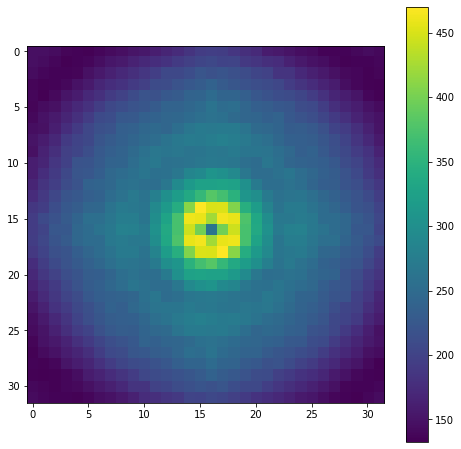

In [41]:
plt.imshow(jnp.fft.fftshift(sigma_noise.reshape([32,32]))); plt.colorbar()

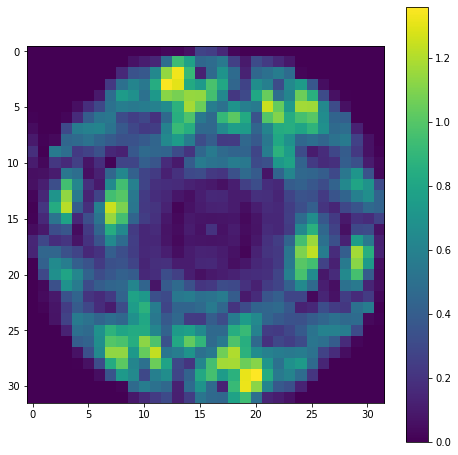

In [42]:
i = 100
s0 = slice_func(vcg1, angles_rec[i], shifts[i], ctf_params[i])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

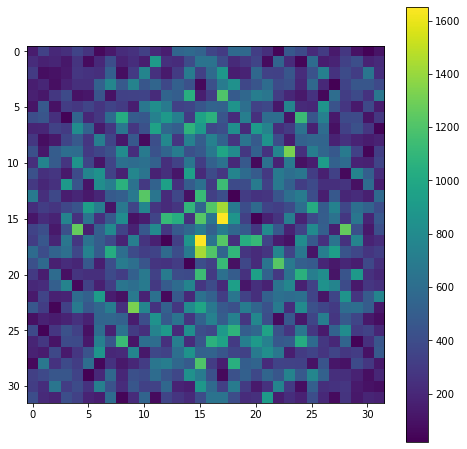

In [43]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[i]).reshape(nx,nx))); plt.colorbar()

In [44]:
resid = s0 - imgs_f[i]
d = jnp.real(jnp.conj(resid)*resid)/(2*sigma_noise**2)

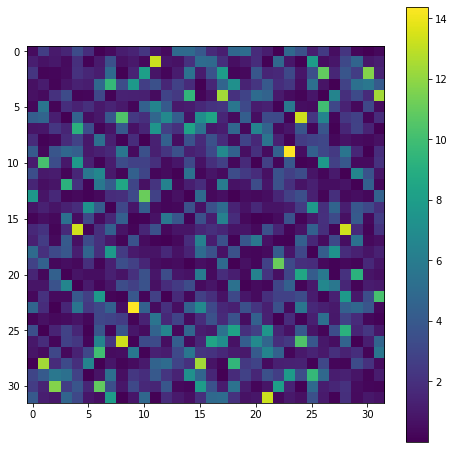

In [45]:
plt.imshow(jnp.fft.fftshift(d.reshape([32,32]))); plt.colorbar()

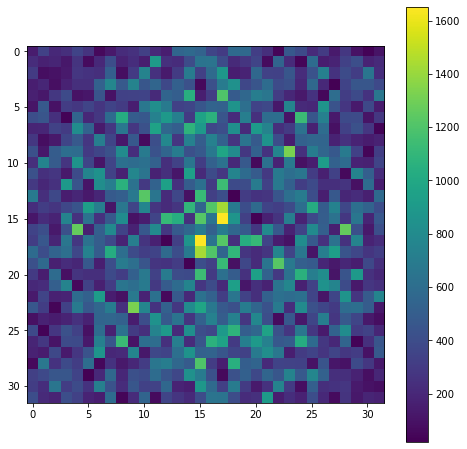

In [46]:
plt.imshow(jnp.abs(jnp.fft.fftshift(resid.reshape([32,32])))); plt.colorbar()

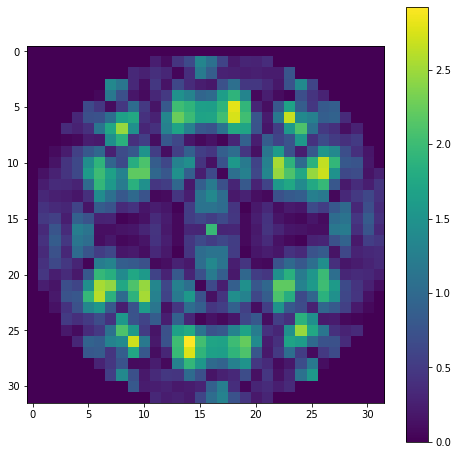

In [47]:
plt.imshow(jnp.fft.fftshift(jnp.abs(vcg1[:,0,:]))); plt.colorbar()

In [48]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec))))
plt.colorbar()
plt.title('Reconstruction MIP')

NameError: name 'v_rec' is not defined

Text(0.5, 1.0, 'Reconstruction MIP')

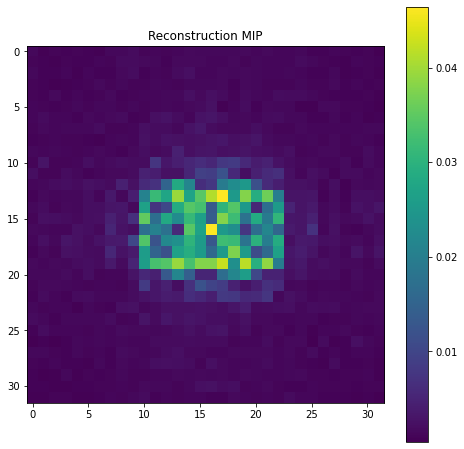

In [49]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))))
plt.colorbar()
plt.title('Reconstruction MIP')

In [319]:
vr1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))) 

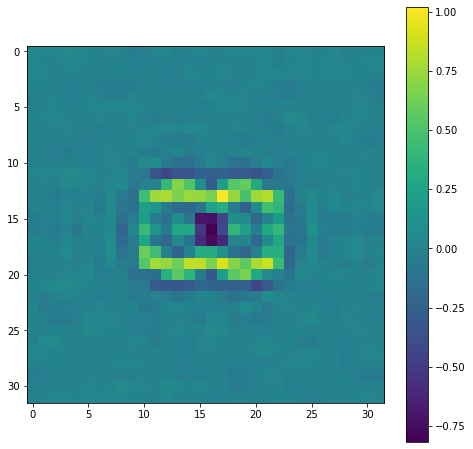

In [320]:
plt.imshow(vr1[:,:,16]); plt.colorbar()

In [321]:
verr = vcg1 - v_rec
plt.imshow(jnp.abs(jnp.fft.fftshift(verr[0,:,:]))); plt.colorbar()

NameError: name 'v_rec' is not defined

In [322]:
jnp.max(jnp.abs(vcg1))

DeviceArray(116.88976, dtype=float64)

In [323]:
jnp.max(jnp.abs(v_rec))

NameError: name 'v_rec' is not defined

### Write volume to file

In [324]:
with mrcfile.new('../data/reconstruction_data_32_cg.mrc', overwrite=True) as mrc:
    mrc.set_data(vr1.astype(np.float32))

### CG - choosing $\alpha$

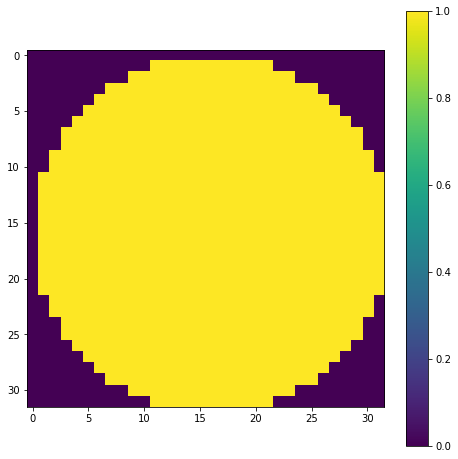

In [32]:
centre = (0,0,0)
radius = 0.05
mask = create_3d_mask(x_grid, centre, radius)
mask2d = mask[:,:,0]

plt.imshow(jnp.fft.fftshift(mask2d)); plt.colorbar()

First, the slice function and the data fidelity function (i.e. the loss function with $\alpha=0$):

In [33]:
slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
fid_func, fid_func_batched, fid_func_sum, _ = get_loss_funcs(slice_func, alpha = 0)

Estimate the noise:

sigma noise min = 204.76153564453125
sigma noise max = 553.5657348632812
sigma noise mean = 437.07058238983154


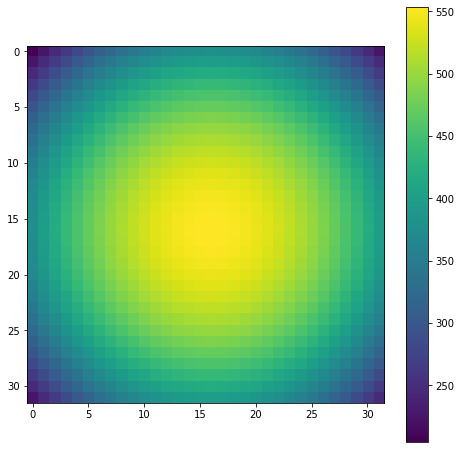

In [36]:
print("sigma noise min =", jnp.min(sigma_noise))
print("sigma noise max =", jnp.max(sigma_noise))
print("sigma noise mean =", jnp.mean(sigma_noise))

#sigma_noise = jnp.max(sigma_noise)*jnp.ones(sigma_noise.shape)
plt.imshow(jnp.fft.fftshift(sigma_noise.reshape([nx,nx]))); plt.colorbar()

In [37]:
imgs_f_m = imgs_f * mask2d.reshape(-1)

In [40]:
N_iter = 50100
#eps = 3e-5
eps = 1e-3
#eps = 1e-4
v0 = jnp.zeros([nx,nx,nx])* 1j
alphas = [1e-7, 1.1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
vcgs = []
fids = []
regs = []
losss = []

In [41]:
N_alpha = len(alphas)
for alpha in alphas[:N_alpha]:
    t0 = time.time()
    print('alpha =', alpha)
    
    loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
    grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)
    
    AA, Ab = get_cg_vol_ops(grad_loss_volume_sum, angles_rec, shifts, ctf_params, imgs_f_m, v0.shape, sigma_noise)
    vcg, _ = conjugate_gradient(AA, Ab, v0, N_iter, eps, verbose = True)
    
    fid = 2*fid_func_sum(vcg, angles_rec, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    reg = l2sq(vcg)/(nx*nx*nx)
    loss = loss_func_sum(vcg, angles_rec, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    
    vcgs.append(vcg)
    fids.append(fid)
    regs.append(reg)
    losss.append(loss)
    
    print("  fid =", fid)
    print("  reg =", reg)
    print("  loss =", loss)
    
    print("  Time =", time.time() - t0)
    
vcgs = jnp.array(vcgs)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

alpha = 1e-07
  cg iter 0 ||r|| = 0.0007242491734986465
  fid = 0.8863608965234971
  reg = 4425.537558297036
  loss = 0.4502613083550238
  Time = 19.497355222702026
alpha = 1.1e-06
  cg iter 0 ||r|| = 0.00013361830293522718
  fid = 0.9213518375279938
  reg = 150.6336215009199
  loss = 0.46332707050241295
  Time = 10.530154943466187
alpha = 1e-05
  cg iter 0 ||r|| = 1.618042923883608e-05
  fid = 0.9311424558222897
  reg = 2.2088696669164176
  loss = 0.46592464705785147
  Time = 10.616731643676758
alpha = 0.0001
  cg iter 0 ||r|| = 1.636401820407267e-06
  fid = 0.9324203718577485
  reg = 0.022592792947061655
  loss = 0.4662463343975895
  Time = 10.503710985183716
alpha = 0.001
  cg iter 0 ||r|| = 1.6382606498676288e-07
  fid = 0.932550563844798
  reg = 0.00022644149526754813
  loss = 0.46627890498632324
  Time = 11.798192024230957
alpha = 0.01
  cg iter 0 ||r|| = 1.6384467651069754e-08
  fid = 0.9325636074513786
  reg = 2.26492948136441e-06
  loss = 0.46628216611440637
  Time = 10.401191

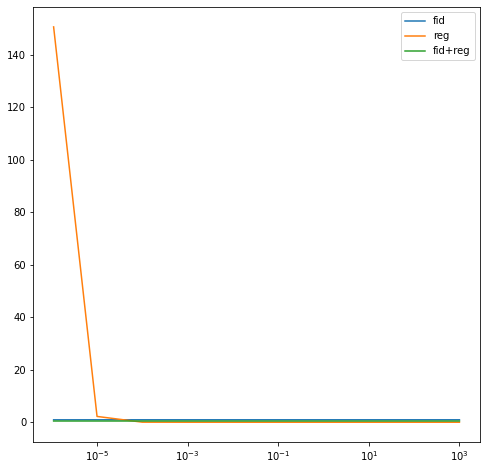

In [42]:
plt.semilogx(alphas[1:], fids[1:])
plt.semilogx(alphas[1:], regs[1:])
plt.semilogx(alphas[1:], losss[1:])
plt.legend(['fid', 'reg', 'fid+reg'])

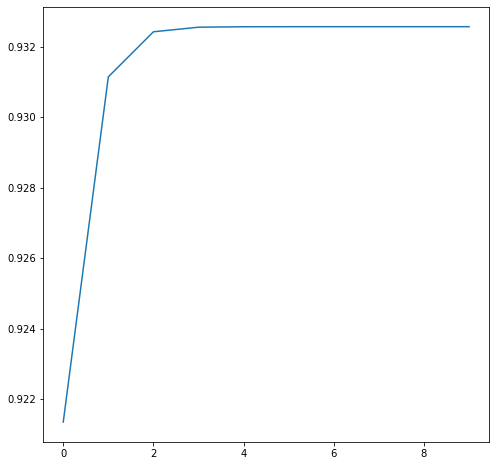

In [43]:
plt.plot(fids[1:])

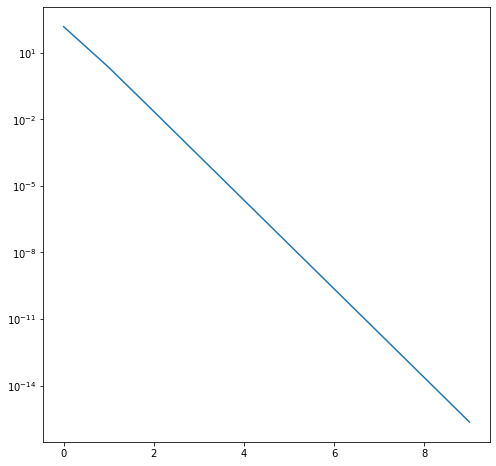

In [44]:
plt.semilogy(regs[1:])

In [45]:
def pixel_wise_fid_fun(v, slice_func_array, angles_, shifts, ctf_params, imgs, sigma):
    err = slice_func_array(v, angles, shifts, ctf_params) - imgs
    return jnp.mean(jnp.real(jnp.conj(err)*err), axis = 0)/(2*sigma**2)
    #return jnp.mean(jnp.real(jnp.conj(err)*err), axis = 0)/2

Pixel-wise loss for the best reconstruction:

In [46]:
alphas[alpha_idx]

DeviceArray(1.e-07, dtype=float64)

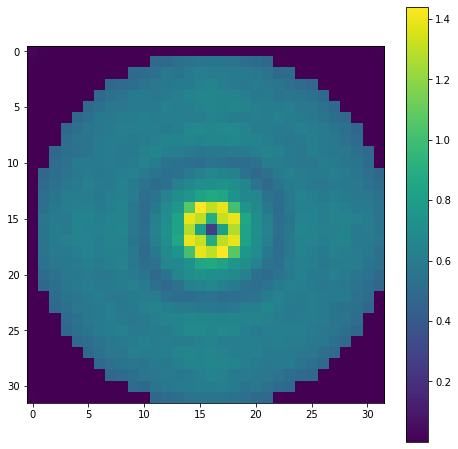

In [47]:
pw_fid = pixel_wise_fid_fun(vcgs[alpha_idx], slice_func_array, angles_rec, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid.reshape([nx,nx]))); plt.colorbar()

Pixel-wise loss for the ZERO volume:

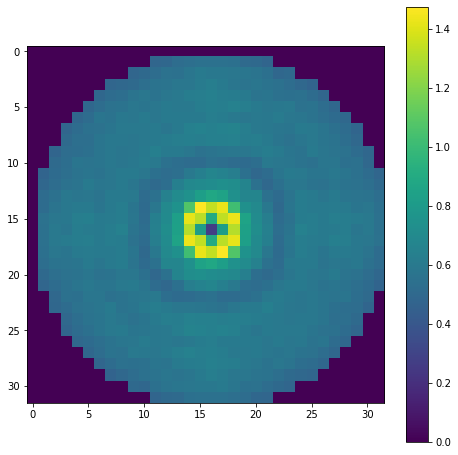

In [48]:
pw_fid0 = pixel_wise_fid_fun(jnp.zeros(v0.shape), slice_func_array, angles_rec, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid0.reshape([nx,nx]))); plt.colorbar()

In [52]:
alpha_idx = jnp.argmin(fids)
print(alpha_idx)

0


In [65]:
alpha_idx = 7

1.0


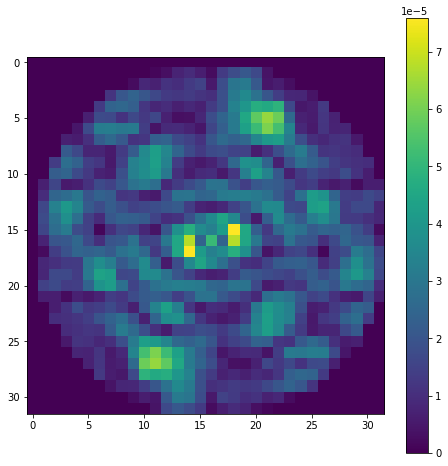

In [66]:
print(alphas[alpha_idx])
plt.imshow(jnp.abs(jnp.fft.fftshift(vcgs[alpha_idx][:,0,:]))); plt.colorbar()

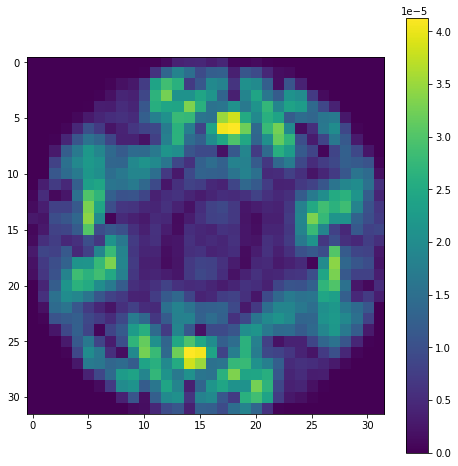

In [67]:
img_idx = 100
s0 = slice_func(vcgs[alpha_idx], angles_rec[img_idx], shifts[img_idx], ctf_params[img_idx])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

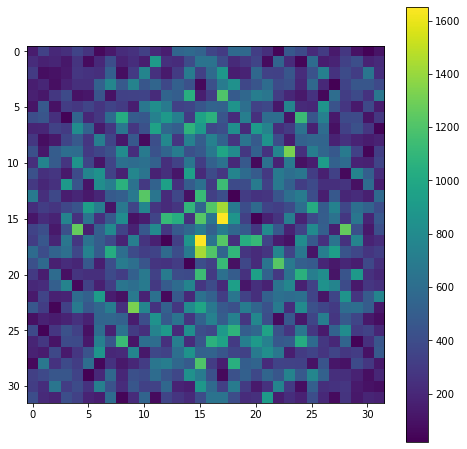

In [68]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[img_idx]).reshape(nx,nx))); plt.colorbar()

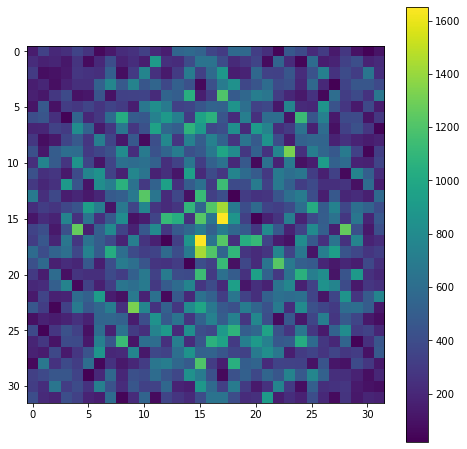

In [69]:
plt.imshow(jnp.fft.fftshift(jnp.abs(s0 - imgs_f[img_idx]).reshape(nx,nx))); plt.colorbar()

Text(0.5, 1.0, 'Reconstruction MIP')

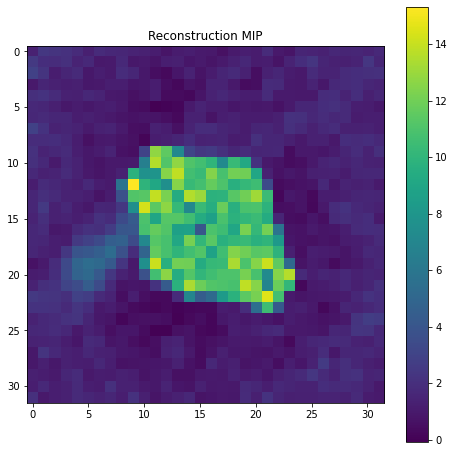

In [70]:
vr_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(vr_rec)
plt.colorbar()
plt.title('Reconstruction MIP')

Text(0.5, 1.0, 'Reconstruction MIP')

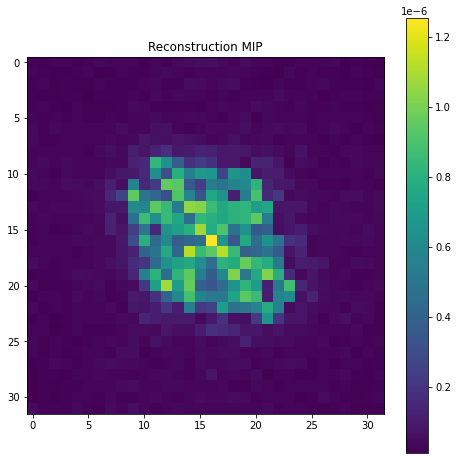

In [71]:
vcg_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcgs[alpha_idx])))
mip_z(vcg_r)
plt.colorbar()
plt.title('Reconstruction MIP')

In [72]:
with mrcfile.new('../data/reconstruction_data_32_cg_alpha2.mrc', overwrite=True) as mrc:
    mrc.set_data(vcg_r.astype(np.float32))

### All images are the same, with different scalings (corresponding to different orders of $\alpha$)

In [73]:
vcgs_s = vcgs[:,:,0,0]
vcgs_s.shape

(11, 32)

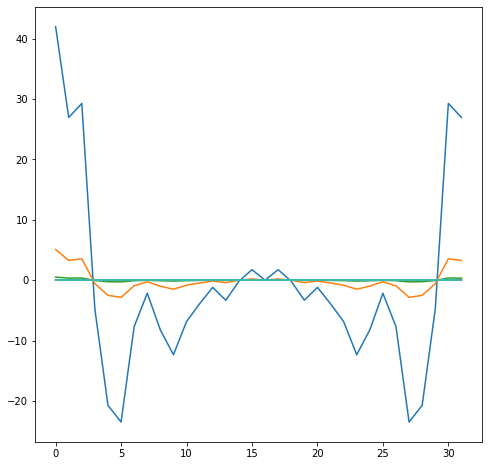

In [74]:
for i in range(1,11):
    plt.plot(jnp.real(vcgs_s[i]))

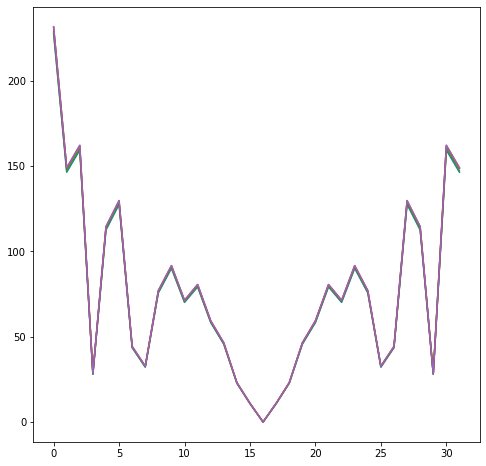

In [81]:
plt.plot(jnp.abs(vcgs_s[0]))
plt.plot(jnp.abs(vcgs_s[1])*5.5)
plt.plot(jnp.abs(vcgs_s[2])*45)
plt.plot(jnp.abs(vcgs_s[3])*450)
plt.plot(jnp.abs(vcgs_s[10])*4.5e9)


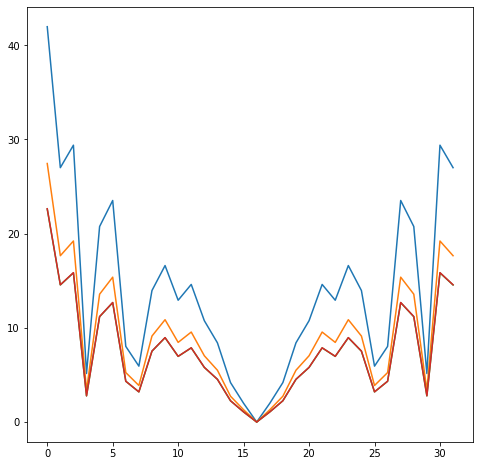

In [76]:
#plt.plot(jnp.abs(vcgs_s[0]))
plt.plot(jnp.abs(vcgs_s[1]))
plt.plot(jnp.abs(vcgs_s[2])*5.4)
plt.plot(jnp.abs(vcgs_s[3])*44)
plt.plot(jnp.abs(vcgs_s[10])*4.4e8)

### FSC, orientations, standard deviation for each voxel etc

In [29]:
vcg2=vcg1

In [30]:
#dr = 0.01
dr = 0.05
res, fsc, shell_points = calc_fsc(vcg1, vcg2, x_grid, dr)


In [153]:
angles[:50].shape

(50, 3)

In [21]:
rc = rotate_list(x_grid, angles[:2])
_,(_,xyz_idxs) = jax.vmap(find_nearest_eight_grid_points_idx, in_axes = (1,None, None, None))(rc, x_grid, x_grid, x_grid)

In [29]:
#jnp.array_split(xyz_idxs, 100)

In [28]:
points_v_tri = points_orientations_tri(angles, x_grid[1].astype(jnp.int64), number_of_batches = 100)
#points_v_nn = points_orientations_nn(angles[:1000], x_grid[1])

Rotating coordinates
Finding point indices
Splitting in batches.
Adding up number of points from batches.


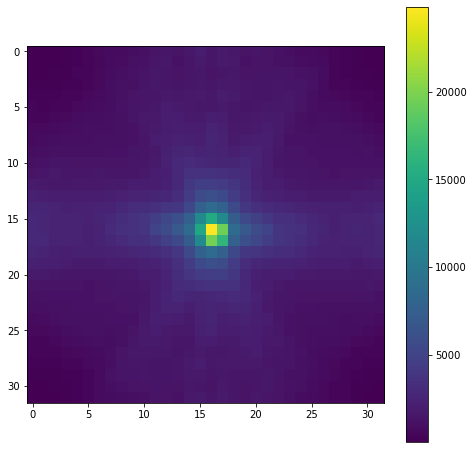

In [18]:
plt.imshow(jnp.fft.fftshift(points_v_tri[:,:,0])); plt.colorbar()

In [ ]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid, dr = 0.05)

In [ ]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines([0.143, 0.5], xmin=min(res), xmax=max(res), colors = ['gray'], linestyles=['dashed'])
plt.legend(['FSC', 'fraction shell points used', '0.143, 0.5'])
#plt.title('Clustered angles')

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[0,:,:]*mask[0,:,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,0,:]*mask[:,0,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,:,0]*mask[:,:,0]))))); plt.colorbar()

In [ ]:
vones = jnp.ones(vcg1.shape)
omega = AA1(vones)
omega = 1/omega

In [ ]:
plt.title("Standard deviation")
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[0,:,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[:,0,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[:,:,0]))))); plt.colorbar()

### SGD

### Preconditioner

In [69]:
points_v_nn.shape
P2 = points_v_nn
P2 += 1
P2 = (1/P2**0.1 ) * mask

P2 = P2/jnp.max(P2)

plt.imshow(jnp.fft.fftshift(P2[:,:,0]));plt.colorbar()
print(P2[0,0,0])
print(jnp.max(P2))
print(jnp.min(P2))

NameError: name 'points_v_nn' is not defined

1e-06
1.000001
1e-06


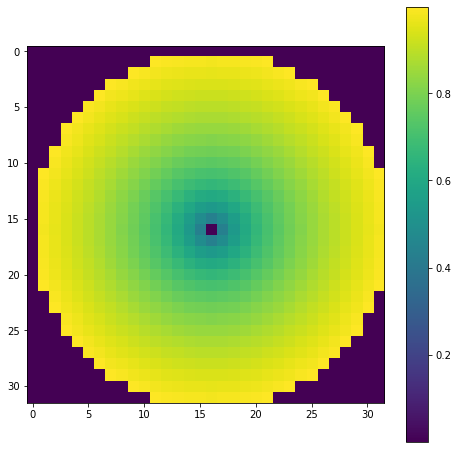

In [34]:
P = get_preconditioner(x_grid) * mask
#P = jnp.sqrt(P) /jnp.max(P) + 1e-6
#P = jnp.sqrt(P)
P = P**0.15
P = P /jnp.max(P)+ 1e-6
plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))
print(jnp.min(P))

### Points/orientations preconditioner

0.02275106763759302
1.0
0.0


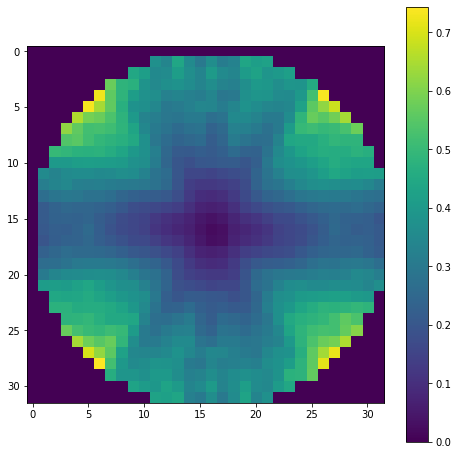

In [29]:
P = points_v_tri +1
P = 1/P * mask + 1e-12
P = P/jnp.max(P) * mask
plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))
print(jnp.min(P))

### $\alpha$ tuning

In [82]:
imgs_f_m = imgs_f * mask2d.reshape(-1)

In [83]:
N_epoch = 50100
batch_size = N/4
number_of_batches = N/batch_size
#learning_rate = 100000
learning_rate = 10000

P = None

eps = 3e-5
#eps = 1e-3
#eps = 1e-9
v0 = jnp.zeros([nx,nx,nx])* 1j
alphas = [1e-8, 1e-7, 1.1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
#alphas = [1e-13]


In [84]:
vgds = []
fids = []
regs = []
losss = []

#N_alpha = 4
for alpha in alphas:
    t0 = time.time()
    print('alpha =', alpha)
    
    slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
    loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)

    grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

    sgd_grad_func = get_sgd_vol_ops(grad_loss_volume_batched, angles_rec, shifts, ctf_params, imgs_f_m, sigma_noise)
    
    vgd = sgd(sgd_grad_func, N, v0, learning_rate, N_epoch, batch_size, P, eps, verbose = True)
    
    fid = 2*fid_func_sum(vgd, angles_rec, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    reg = l2sq(vgd)/(nx*nx*nx)
    loss = loss_func_sum(vgd, angles_rec, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    
    vgds.append(vgd)
    fids.append(fid)
    regs.append(reg)
    losss.append(loss)
    
    print("  fid =", fid)
    print("  reg =", reg)
    print("  loss =", loss)
    
    print("  Time =", time.time() - t0)
    
vgds = jnp.array(vgds)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

alpha = 1e-08
  sgd epoch 0: mean gradient = 8.675207035005959e-07
  fid = 0.9319878557931502
  reg = 0.36092605228256497
  loss = 0.4659939856447436
  Time = 15.983287572860718
alpha = 1e-07
  sgd epoch 0: mean gradient = 8.643965267008079e-07
  fid = 0.9319886370576052
  reg = 0.3599472198990349
  loss = 0.4659948944443545
  Time = 12.907403707504272
alpha = 1.1e-06
  sgd epoch 0: mean gradient = 8.302556450507854e-07
  fid = 0.9319972011118647
  reg = 0.34930633215170603
  loss = 0.4660047483473783
  Time = 15.88776159286499
alpha = 1e-05
  sgd epoch 0: mean gradient = 5.695352164585924e-07
  fid = 0.9320687584433724
  reg = 0.2667478359211499
  loss = 0.46607705887543355
  Time = 13.112367868423462
alpha = 0.0001
  sgd epoch 0: mean gradient = 2.340787858859482e-08
  fid = 0.9324210577080018
  reg = 0.024081543062648664
  loss = 0.46624905932290106
  Time = 13.380016565322876
alpha = 0.001
  sgd epoch 0: mean gradient = 0.006290944527282587
  sgd epoch 50: mean gradient = 4.5803314

KeyboardInterrupt: 

In [88]:
vgds = jnp.array(vgds)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

N_alpha = 5

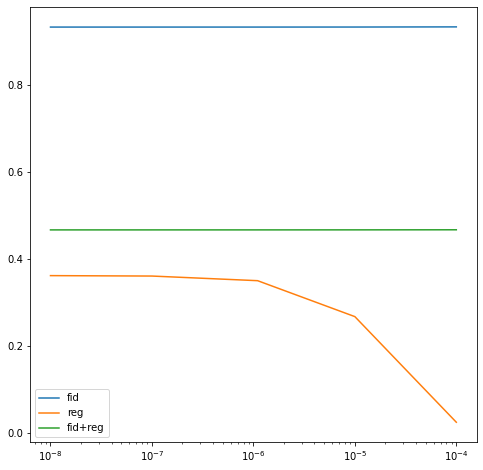

In [89]:
plt.semilogx(alphas[:N_alpha], fids)
plt.semilogx(alphas[:N_alpha], regs)
plt.semilogx(alphas[:N_alpha], losss)
plt.legend(['fid', 'reg', 'fid+reg'])

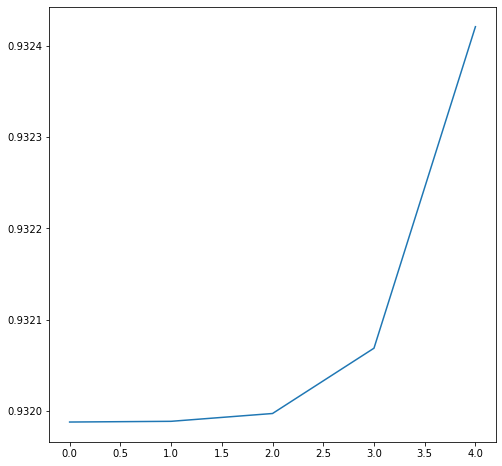

In [90]:
plt.plot(fids)

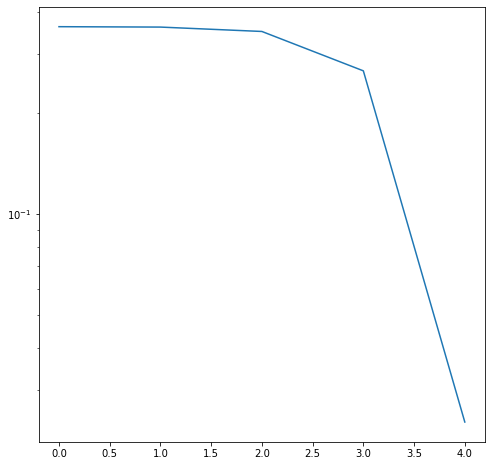

In [91]:
plt.semilogy(regs)

In [92]:
#alpha_idx= 3
alpha_idx

DeviceArray(0, dtype=int64)

1.4739266654732721


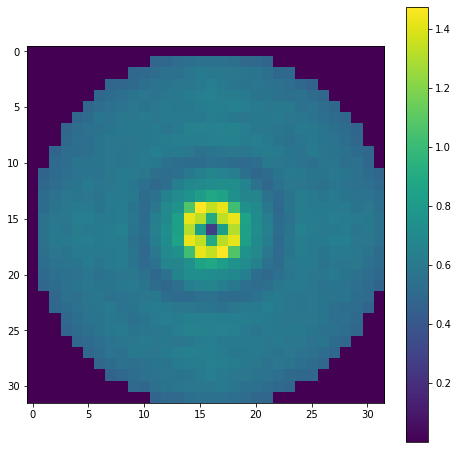

In [93]:
pw_fid = pixel_wise_fid_fun(vgds[alpha_idx], slice_func_array, angles_rec, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid.reshape([nx,nx]))); plt.colorbar()
print(jnp.max(pw_fid))

1.4739266654732721


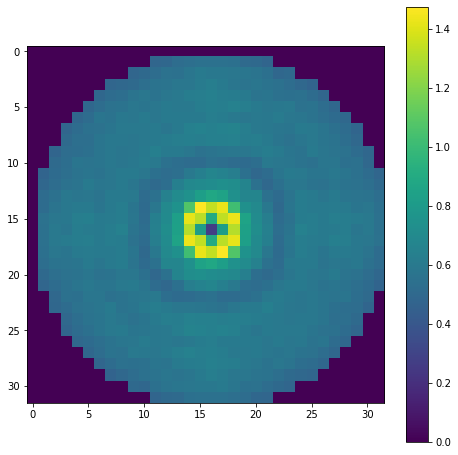

In [94]:
pw_fid0 = pixel_wise_fid_fun(jnp.zeros(vgd.shape), slice_func_array, angles_rec, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid0.reshape([nx,nx]))); plt.colorbar()
print(jnp.max(pw_fid))

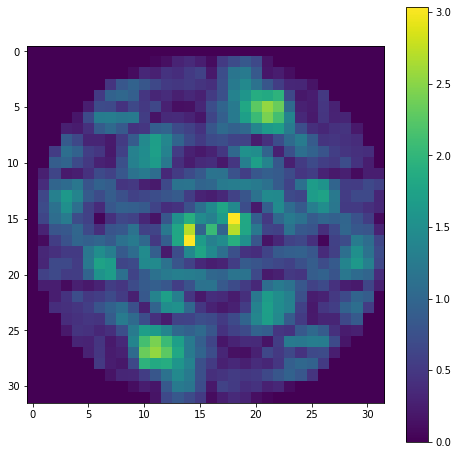

In [95]:
plt.imshow(jnp.fft.fftshift(jnp.abs(vgds[alpha_idx,:,0,:]))); plt.colorbar()

In [120]:
plt.imshow(jnp.fft.fftshift(jnp.abs(v_rec[:,0,:]))); plt.colorbar()

NameError: name 'v_rec' is not defined

In [121]:
err = vgd - v_rec
plt.imshow(jnp.fft.fftshift((jnp.abs(err[:,0,:]))*mask[:,0,:])); plt.colorbar()

NameError: name 'v_rec' is not defined

NameError: name 'v_rec' is not defined

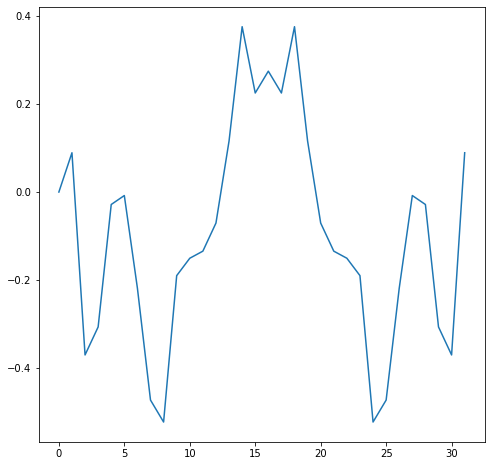

In [122]:
plt.plot(jnp.fft.fftshift(jnp.real(vgd[0,:,0])))
plt.plot(jnp.fft.fftshift(jnp.real(v_rec[0,:,0])))
plt.plot(jnp.fft.fftshift(jnp.real(imgs_f[idx].reshape([32,32])[0,:])))
plt.legend(['vgd', 'vrec', 'img'])

In [ ]:
jnp.max(jnp.abs(imgs_f))

In [96]:
vr_sgd = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vgds[alpha_idx])))

Text(0.5, 1.0, 'Reconstruction MIP')

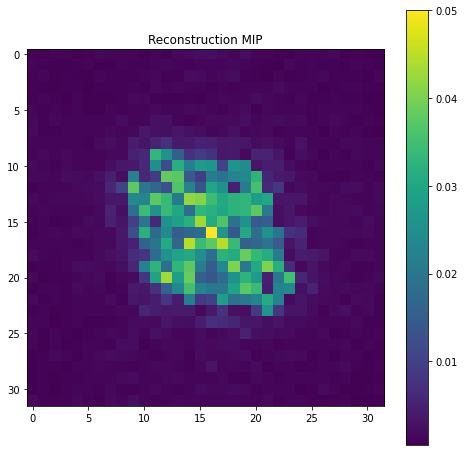

In [97]:
mip_z(vr_sgd)
plt.colorbar()
plt.title('Reconstruction MIP')

Text(0.5, 1.0, 'Reconstruction MIP')

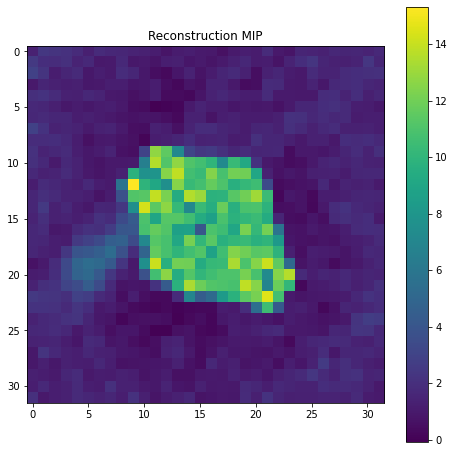

In [98]:
vr_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(vr_rec)
plt.colorbar()
plt.title('Reconstruction MIP')

In [99]:
with mrcfile.new('../data/reconstruction_data_32_sgd.mrc', overwrite=True) as mrc:
    mrc.set_data(vr_sgd.astype(np.float32))

In [100]:
idx = 100

In [101]:
slicegd = slice_func(vgds[alpha_idx], angles[idx], shifts[idx], ctf_params[idx])
#slicerec = slice_func(v_rec, angles[idx], shifts[idx], ctf_params[idx])

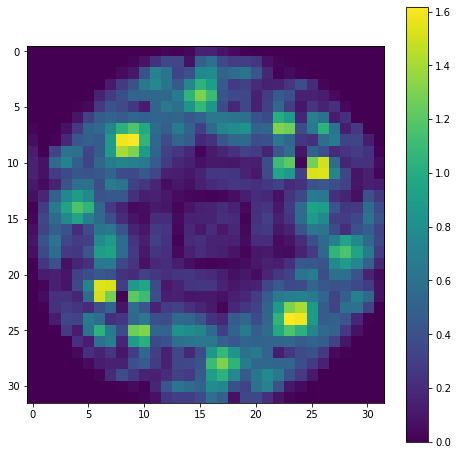

In [102]:
plt.imshow(jnp.abs(jnp.fft.fftshift(slicegd.reshape([32,32])))); plt.colorbar()

In [103]:
plt.imshow(jnp.abs(jnp.fft.fftshift(slicerec.reshape([32,32])))); plt.colorbar()

NameError: name 'slicerec' is not defined

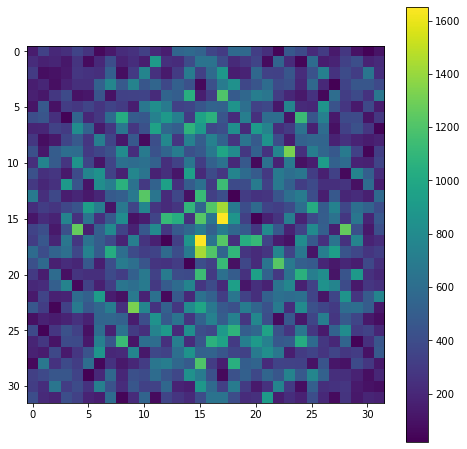

In [104]:
plt.imshow(jnp.abs(jnp.fft.fftshift(imgs_f[idx].reshape([32,32])))); plt.colorbar()

In [134]:
print(1/2*wl2sq(slicegd, imgs_f[idx], 1/sigma_noise**2))
print(1/2*wl2sq(slicerec, imgs_f[idx], 1/sigma_noise**2))

553.343876582564


NameError: name 'slicerec' is not defined

In [355]:
lossgd = loss_func_sum(vgd, angles, shifts, ctf_params, imgs_f, sigma_noise)
lossrec = loss_func_sum(v_rec, angles, shifts, ctf_params, imgs_f, sigma_noise)

print(lossgd)
print(lossrec)

NameError: name 'v_rec' is not defined

In [356]:
alpha0 = 0 

loss_func0, loss_func_batched0, loss_func_sum0, _ = get_loss_funcs(slice_func, alpha = alpha0)
grad_loss_volume0, grad_loss_volume_batched0, grad_loss_volume_sum0 = get_grad_v_funcs(loss_func0, loss_func_sum0)

In [269]:
lossgd0 = loss_func_sum0(vgd, angles, shifts, ctf_params, imgs_f)
lossrec0 = loss_func_sum0(v_rec, angles, shifts, ctf_params, imgs_f)

print(lossgd0)
print(lossrec0)

117666.1786326568
125930.4384133436


In [270]:
reg_term = lambda v, alpha : 1/(2*v.shape[-1]**2) * alpha * l2sq(v)

In [276]:
print(reg_term(vgd, alpha) + lossgd0)
print(reg_term(v_rec, alpha) + lossrec0)

118950.80871989178
324801.5763731515


In [281]:
imgs_f.shape

(4501, 1024)

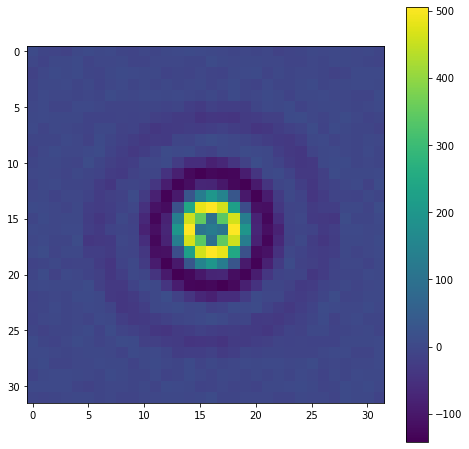

In [395]:
imgs_mean = jnp.mean(jnp.real(imgs_f), axis=0)
plt.imshow(jnp.fft.fftshift((imgs_mean.reshape([32,32]))))
plt.colorbar()

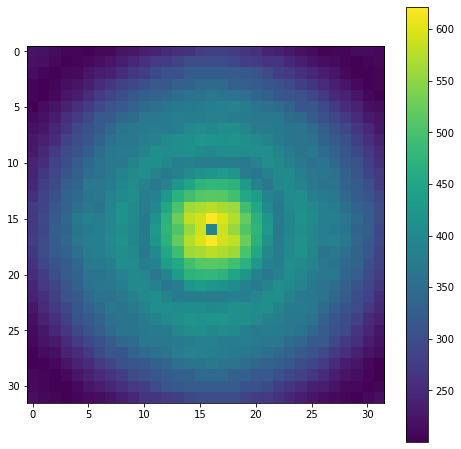

In [373]:
imgs_sd = jnp.sqrt(jnp.mean((jnp.real(imgs_f)-imgs_mean)**2, axis=0))
plt.imshow(jnp.fft.fftshift(imgs_sd.reshape([32,32])))
plt.colorbar()

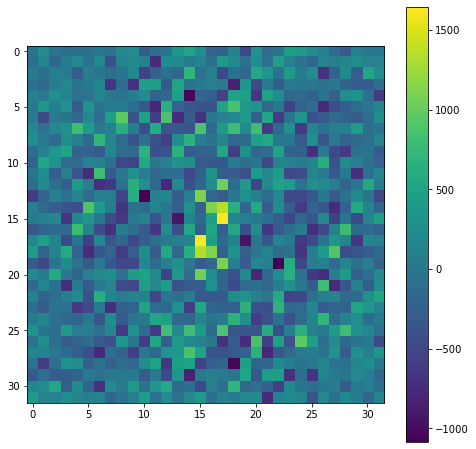

In [397]:
plt.imshow(jnp.real(jnp.fft.fftshift(imgs_f[idx].reshape([32,32])))); plt.colorbar()

In [380]:
img_idx = jnp.fft.fftshift(imgs_f[idx].reshape([32,32]))

In [443]:
sigma_noise = estimate_real_noise(jnp.abs(imgs_f))

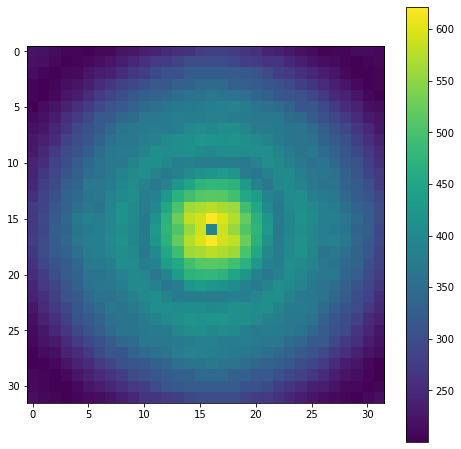

In [437]:
plt.imshow(jnp.fft.fftshift(sd_real.reshape([32,32]))); plt.colorbar()